In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from src.utils.plot import plot_normalized_positions
from src.utils.paths import paths_no_backtrack, get_pairs_with_defined_distance
from src.utils.probs import posterior_probabilites, entropies_prior_posterior, information_gain
from src.utils.distances import compute_distances
from src.utils.load_data import load_data
from src.scripts.generate_embeddings_distances import get_embeddings_distances

## 1. Data loading and pre-processing

In [108]:
articles, categories, links, paths_finished_humans, paths_finished_llm_no_memory, paths_finished_llm_memory, paths_unfinished_humans, paths_unfinished_llm_no_memory, paths_unfinished_llm_memory = load_data()

### Exploring correlations

Here we evaluate the correlation between the difficulty and the path length for human games. 
We observe that the rating is positively correlated with the path length.
R2 shows that our model explains some of the variance of the data.
p is close to 0 which shows that the rating is a good predictor for the path length.

In [109]:
# Compute descriptive statistics human and LLM finished paths lengths
paths_finished_humans['path_length'] = paths_finished_humans['path'].apply(len)
print(paths_finished_humans['path_length'].describe())
print(paths_finished_llm_no_memory.apply(len).describe())

count    51307.000000
mean         6.758668
std          4.680461
min          2.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64
count    14527.000000
mean         4.661527
std          1.612817
min          2.000000
25%          4.000000
50%          4.000000
75%          6.000000
max         17.000000
Name: path, dtype: float64


In [110]:
# Analyze the ratings given by humans
paths_finished_humans['rating'].describe()

count    28501.000000
mean         2.269780
std          1.110439
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rating, dtype: float64

In [111]:
mod = smf.ols(formula='path_length ~ rating', data=paths_finished_humans)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            path_length   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     5551.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:45:13   Log-Likelihood:                -84559.
No. Observations:               28501   AIC:                         1.691e+05
Df Residuals:                   28499   BIC:                         1.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4686      0.063     38.950      0.000       2.344       2.593
rating         1.8687      0.025     74.502      0.000       1.819       1.918
==============================================================================
Omnibus:                    73824.614   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6510845304.372
Skew:                          29.186   Prob(JB):                         0.00
Kurtosis:                    2343.773   Cond. No.                         6.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Compute probabilities and entropies

### 2.A. Prior click probability

Our prior on the click probabilities is the uniform distribution over the out-links of each article. That is, before we have seen the actual game paths that were taken, we assume that the players just one of the out-links from their current article at random. Hence, the prior probability of clicking on the out-link $a'$ when one is on article $a$ with goal $g$ only depends on the number of out-links (the out-degree) of the current article $a$.  We write this as:

$$
P^0(A' = a' \mid A = a, G = g) = \frac{1}{L_a}.
$$

with $L_a$ the number of out-links of $a$.

In [112]:
# Count the out-links of each article to get the probability of clicking on any of them
out_degree = links.groupby('linkSource').size()
probs_prior = 1 / out_degree
# Create a Series indexed by 'linkSource' that gives a list of all the source’s out-links
out_links = links.groupby('linkSource')['linkTarget'].agg(list)

### 2.B. Posterior click probability

These are the probability distributions of clicking on an out-link $a'$ when we are on article $a$ with goal $g$, computed by taking into account the game paths. It is computed as follows:

$$
P^*(A' = a' \mid A = a, G = g) = \frac{N(A' = a', A = a, G = g) + \alpha}{N(A = a, G = g) + \alpha L_a},
$$
where $\alpha$ is the Dirichlet parameter representing the initial confidence in the uniform prior distribution, $L_a$ is $a$'s out-degree (i.e., the number of articles linked from $a$), $N(A = a, G = g)$ is the number of times $a$ was encountered on paths for which $g$ was the goal, and $N(A' = a', A = a, G = g)$ counts how often the link to $a'$ was chosen in this situation.

In [113]:
paths_finished_humans = paths_no_backtrack(paths_finished_humans['path'])
probs_posterior_humans = posterior_probabilites(paths_finished_humans, out_links, out_degree)
probs_posterior_llm_no_memory = posterior_probabilites(paths_finished_llm_no_memory, out_links, out_degree)
probs_posterior_llm_memory = posterior_probabilites(paths_finished_llm_memory, out_links, out_degree)

KeyboardInterrupt: 

### 2.C. Prior and posterior entropies

Compute the prior and posterior entropy at each article along the path, except for the goal, because entropy is 0 once we have reached the goal. This derives from the standard formula for entropy, using the probability distributions defined above. For each step along each path, we compute the entropy of the probability distribution over the next click at this step. This represents how much information we would need to know which link the player is going to pick next, before or after we have seen the actual game paths data for the prior or posterior etropy respectively.

In [9]:
entropies_prior_humans, entropies_posterior_humans = entropies_prior_posterior(paths_finished_humans, probs_prior, probs_posterior_humans, out_degree)
entropies_prior_llm_no_memory, entropies_posterior_llm_no_memory = entropies_prior_posterior(paths_finished_llm_no_memory, probs_prior, probs_posterior_llm_no_memory, out_degree)
entropies_prior_llm_memory, entropies_posterior_llm_memory = entropies_prior_posterior(paths_finished_llm_memory, probs_prior, probs_posterior_llm_memory, out_degree)

## 3. Split the paths

### 3.A. Compute “information gain”

This represents how much information we gain by looking at the click distribution, as described in section 4 and figure 2 of the paper.

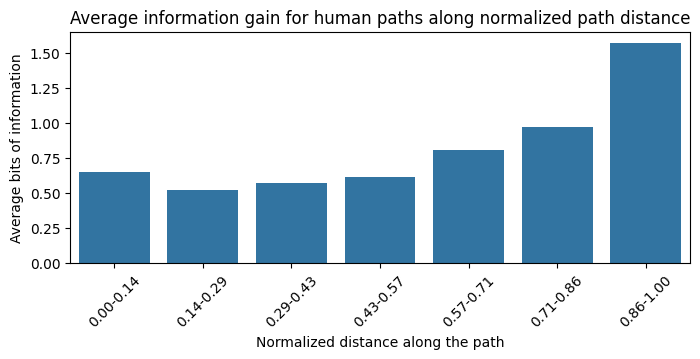

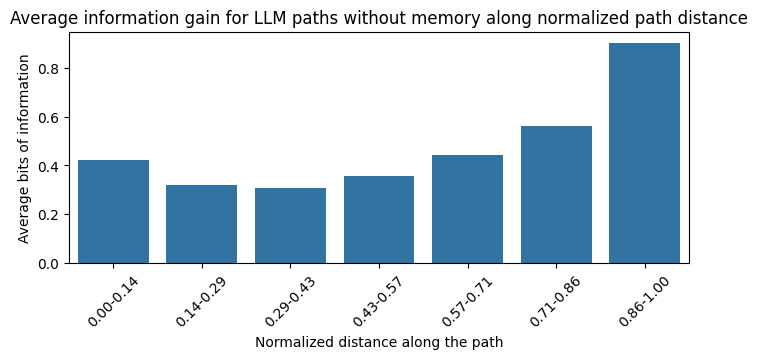

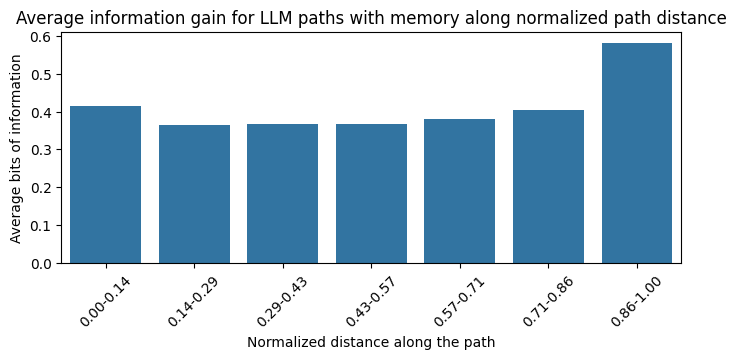

In [10]:
# Compute and plot the information gain for human and for LLM paths
info_gain_humans = information_gain(entropies_prior_humans, entropies_posterior_humans)
info_gain_llm_no_memory = information_gain(entropies_prior_llm_no_memory, entropies_posterior_llm_no_memory)
info_gain_llm_memory = information_gain(entropies_prior_llm_memory, entropies_posterior_llm_memory)
plot_normalized_positions(info_gain_humans, 'information gain for human paths')
plot_normalized_positions(info_gain_llm_no_memory, 'information gain for LLM paths without memory')
plot_normalized_positions(info_gain_llm_memory, 'information gain for LLM paths with memory')

For both humans and the memory-less LLM, we get a U-shaped curve identical to the one obtained in the Wikispeedia paper (figure 2), meaning that seeing the actual game paths makes the first few and the last few steps of the paths much more predictable. This is explained by the strategy that humans have of “getting away” from the starting article to a more general/generic “hub” article, and then “homing in” on the target article by getting more and more specific. We use this fact to split the paths at the point of lowest information gain, which we use as an approximation of the separation of these two parts, and we will then only compute semantic distances on the articles along the “homing in” part to avoid computing distances between the goal and all the unrelated articles that were visited only to get away from the starting point.

We can also see that the LLM without memory seems to exhibit the same behavior, but it is less clear for the LLM with memory, whose curve is not strictly convex. Hence, for the LLM with memory, we cannot clearly separate the paths into these two phases of getting away and homing in by splitting at the point of lowest information gain. Thus, we cannot separate out the irrelevant distances, and the semantic distances we get become harder and less meaningful to analyse. This is why we will mostly set aside the analysis of the semantic distances computed from the LLM with memory.

### 3.B. Get the splitting point and split the paths

In [11]:
# Get the index of the point of lowest information gain for each path
argmin_info_gain_humans = info_gain_humans.apply(np.argmin)
argmin_info_gain_llm_no_memory = info_gain_llm_no_memory.apply(np.argmin)
argmin_info_gain_llm_memory = info_gain_llm_memory.apply(np.argmin)
# Split the path at this point and keep only the second part, corresponding to the “homing in” phase
paths_homing_in_humans = pd.Series([path[argmin_info_gain_humans[i]:] for i, path in paths_finished_humans.items()])
paths_homing_in_llm_no_memory = pd.Series([path[argmin_info_gain_llm_no_memory[i]:] for i, path in paths_finished_llm_no_memory.items()])
paths_homing_in_llm_memory = pd.Series([path[argmin_info_gain_llm_memory[i]:] for i, path in paths_finished_llm_memory.items()])

## 4. Compute embedding distances

We now need to get a list of all the article titles whose embedding we need to compute, as well as the list of pairs of articles between which we need to compute the distance.

In [12]:
# Compute the set of all articles encountered in the paths_homing_in_humans
# Every article encountered along a goal has a defined distance with the goal
all_distance_pairs, all_articles = get_pairs_with_defined_distance(paths_homing_in_humans)

We use the sentence-transformers library to load the pre-trained BERT model and compute embeddings for each of our article titles. Then, we compute distances between these embeddings models, using both cosine similarity and Euclidean distance, which we return in a dataframe `similarities`.

In [13]:
distance_embeddings = get_embeddings_distances(all_articles, all_distance_pairs, 'data/article_similarities.csv')

## 5. Compute semantic distances

We do this in the exact same was as in the Wikipedia paper, whose explanation is as follows:

Considering one particular path $p = \langle a_1, a_2, \ldots, a_n = g \rangle$, we can compute a *path-specific distance* from every article $a_i$ along $p$ to the goal $g$. For every $i$ with $1 \leq i < n$ we get

$$
d_p(a_i, g) = \frac{-\sum_{j=i}^{n-1} \log P^*(A' = a_{j+1} \mid A = a_j, G = g)}{-\log \text{PageRank}(g)}.
$$

In the numerator, $-\log P^*(A' = a_{j+1} \mid A = a_j, G = g)$ is the information content of the link from $a_j$ to $a_{j+1}$ given that the goal is $g$, or in other words, the number of bits needed to represent that link optimally in a Huffman coding. So the numerator sums up the numbers of bits needed to code each separate link that was clicked along $p$, and consequently indicates the number of bits needed to code the entire path (note that this is conditional on $g$).

The denominator contains the Google PageRank [Brin and Page, 1998] of the goal article $g$, which is the stationary probability of $g$ during a (fictional) random walk on the Wikipedia graph.

So far, we have described distances that are derived from single paths. To get a *path-independent distance* from $a$ to $g$, we simply average over all paths running through $a$ and reaching goal $g$. Thus, if there are $m$ such paths $p_1, p_2, ..., p_m$,

$d(a,g) = \frac{1}{m} \sum_{k=1}^m d_{p_k}(a,g)$.

In [14]:
distances_humans = pd.Series(compute_distances(links, probs_posterior_humans, paths_homing_in_humans, 'data/distances_humans.pkl'))
distances_llm_no_memory = pd.Series(compute_distances(links, probs_posterior_llm_no_memory, paths_finished_llm_no_memory, 'data/distances_llm_no_memory.pkl'))
distances_llm_memory = pd.Series(compute_distances(links, probs_posterior_llm_memory, paths_finished_llm_memory, 'data/distances_llm_memory.pkl'))

In [15]:
intersection_index = distances_humans.index.intersection(distances_llm_no_memory.index)
semantic_distances = pd.DataFrame({ 'humans': distances_humans, 'llm_no_memory': distances_llm_no_memory, 'llm_memory': distances_llm_memory}, index=intersection_index)

In [16]:
semantic_distances.describe()

,humans,llm_no_memory,llm_memory
count,15866.000000,15866.000000,5470.000000
mean,0.384870,0.403347,0.372536
std,0.472799,0.268385,0.326953
min,0.000844,0.006247,0.006203
25%,0.176986,0.211733,0.177001
50%,0.316225,0.350472,0.288108
75%,0.498339,0.529106,0.470229
max,37.811398,3.494916,5.068087


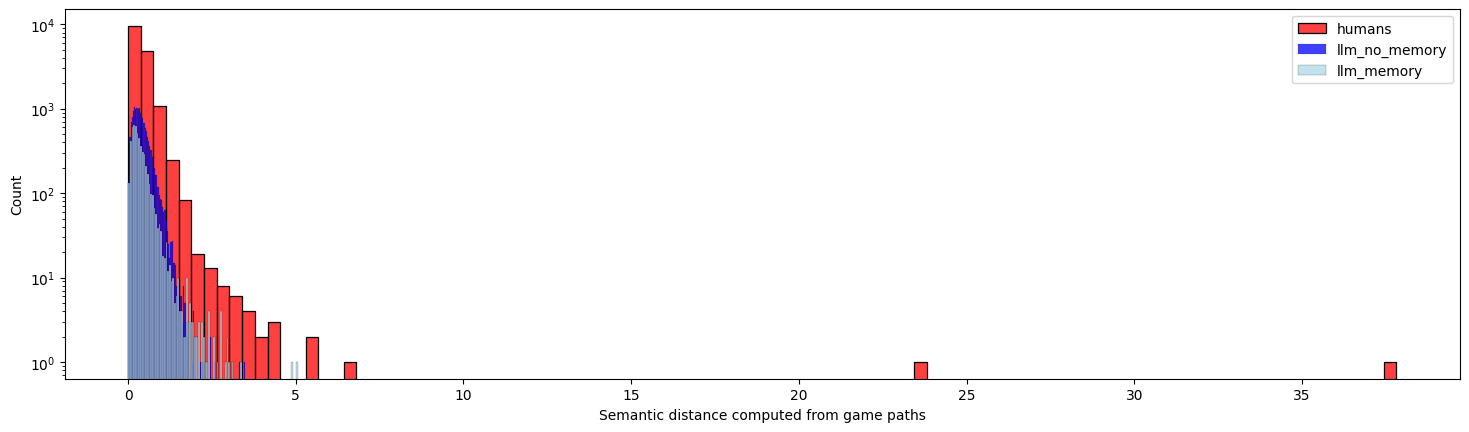

In [17]:
plt.figure().set_figwidth(18)
sns.histplot(semantic_distances['humans'][intersection_index], bins=100, color='red', label='humans')
sns.histplot(semantic_distances['llm_no_memory'][intersection_index], bins=100, color='blue', label='llm_no_memory')
sns.histplot(semantic_distances['llm_memory'][intersection_index], bins=100, color='lightblue', label='llm_memory')
plt.legend()
plt.xlabel('Semantic distance computed from game paths')
plt.yscale('log')

In [18]:
distance_differences_humans_llm_no_memory = pd.Series(distances_humans - distances_llm_no_memory, index=intersection_index)

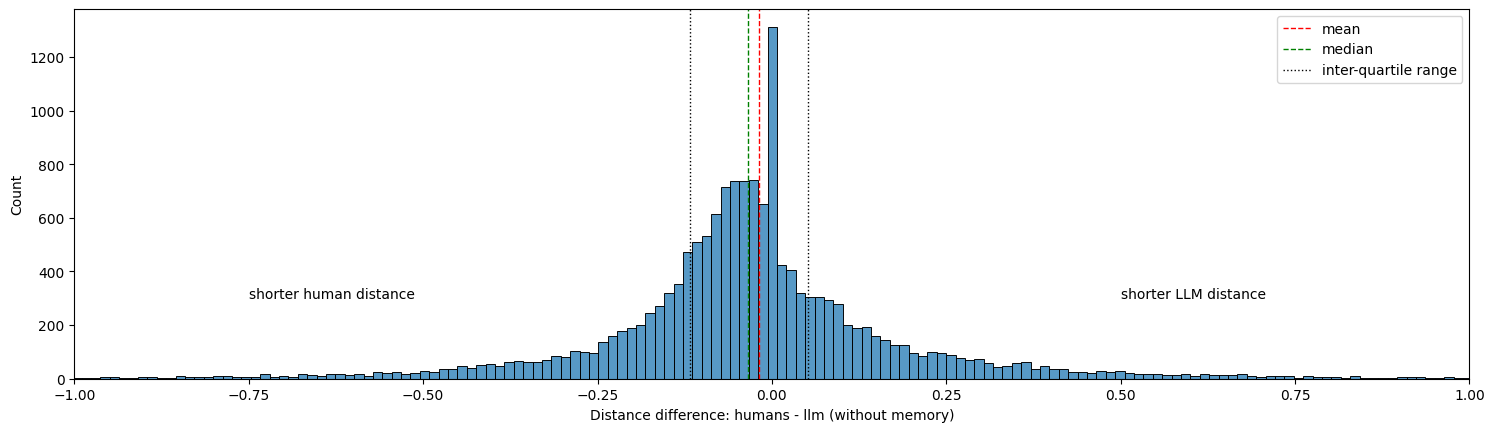

In [19]:
plt.figure().set_figwidth(18)
plt.xlim(-1,1)
sns.histplot(distance_differences_humans_llm_no_memory)
plt.xlabel('Distance difference: humans - llm (without memory)')
plt.text(x=-0.75, y=300, s='shorter human distance')
plt.text(x=0.5, y=300, s='shorter LLM distance')
# make the mean, median visible
plt.axvline(distance_differences_humans_llm_no_memory.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(distance_differences_humans_llm_no_memory.median(), color='green', linestyle='dashed', linewidth=1)
# show the 25th and 75th percentile
plt.axvline(distance_differences_humans_llm_no_memory.quantile(0.25), color='black', linestyle='dotted', linewidth=1)
plt.axvline(distance_differences_humans_llm_no_memory.quantile(0.75), color='black', linestyle='dotted', linewidth=1)
plt.legend(['mean', 'median', 'inter-quartile range'])

In [20]:
distance_differences_humans_llm_no_memory.describe()

count    15866.000000
mean        -0.018477
std          0.450774
min         -3.091321
25%         -0.117988
50%         -0.033702
75%          0.051277
max         37.486572
dtype: float64

In [21]:
# Print the 10 pairs with the highest difference
distance_differences_humans_llm_no_memory.nsmallest(10)

6th_century  20th_century      -3.091321
             Rainforest        -3.091321
             19th_century      -2.781373
1st_century  16th_century      -2.751327
Radio        Ship              -2.353619
Israel       Great_Cormorant   -2.267989
Hydrogen     World_War_II      -1.863525
Gypsum       Italy             -1.795714
6th_century  17th_century      -1.783421
             18th_century      -1.783421
dtype: float64

In [22]:
distance_differences_humans_llm_no_memory.nlargest(10)

English_language  Dutch_language    37.486572
                  Thomas_Hobbes     23.476005
Canada            Japan              6.234154
Force             Cold_War           5.069985
Niger             United_Kingdom     4.832348
                  Arctic_Ocean       3.786992
Amazon_River      Earth              3.759676
Coffee            Human              3.371838
Education         Culture            3.250158
Broadcasting      Scotland           3.184682
dtype: float64

In [23]:
semantic_distances.loc['Canada'].loc['Japan']

humans           6.779325
llm_no_memory    0.545172
llm_memory            NaN
Name: Japan, dtype: float64

In [24]:
semantic_distances.loc['6th_century'].loc['20th_century']

humans           0.231379
llm_no_memory    3.322700
llm_memory       0.373575
Name: 20th_century, dtype: float64

### Compare distances from embeddings to human semantic distances

In [25]:
distance_embeddings['pair'] = distance_embeddings['pair'].apply(lambda x: (x[1], x[0]))

# Create a dictionary that maps each article pair to its cosine similarity
similarity_dict = dict(zip(distance_embeddings['pair'], distance_embeddings['euclidean_distance']))
distances_euclidean = pd.Series(similarity_dict)
distances_euclidean.describe()

count    91844.000000
mean         7.641662
std          2.261004
min          0.000000
25%          6.598946
50%          8.002598
75%          9.092360
max         13.611164
dtype: float64

In [26]:
intersection_index = distances_humans.index.intersection(distances_euclidean.index)
distances_human_embedding_euclidean = pd.DataFrame({'humans': distances_humans, 'embedding': distances_euclidean}, index=intersection_index)
distance_differences_humans_euclidean = pd.Series(distances_humans - distances_euclidean, index=intersection_index)

Text(0.5, 0, 'distance difference humans - embedding (euclidean)')

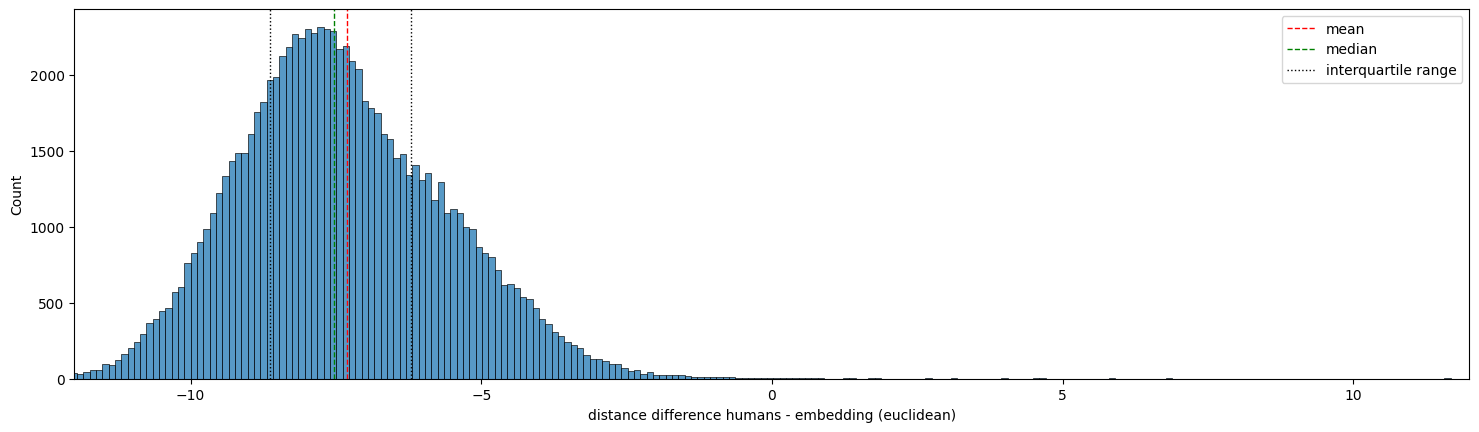

In [27]:
plt.figure().set_figwidth(18)
plt.xlim(-12,12)
sns.histplot(distance_differences_humans_euclidean)
# make the mean, median visible
plt.axvline(distance_differences_humans_euclidean.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(distance_differences_humans_euclidean.median(), color='green', linestyle='dashed', linewidth=1)
# show the 25th and 75th percentile
plt.axvline(distance_differences_humans_euclidean.quantile(0.25), color='black', linestyle='dotted', linewidth=1)
plt.axvline(distance_differences_humans_euclidean.quantile(0.75), color='black', linestyle='dotted', linewidth=1)
plt.legend(['mean', 'median', 'interquartile range'])
plt.xlabel('distance difference humans - embedding (euclidean)')

In [28]:
distance_differences_humans_euclidean.describe()

count    88517.000000
mean        -7.311655
std          2.545317
min        -13.373773
25%         -8.631836
50%         -7.542276
75%         -6.204247
max         59.167579
dtype: float64

### Any patterns in the article pairs where semantic distance differs the most between humans and LLM without memory?

In [29]:
# Get the 10% of pairs for which the LLM and human semantic distances differ the most
distance_differences_humans_llm_no_memory[(distance_differences_humans_llm_no_memory < distance_differences_humans_llm_no_memory.quantile(0.05)) | (distance_differences_humans_llm_no_memory > distance_differences_humans_llm_no_memory.quantile(0.95))]

African_slave_trade  Africa                            0.509929
Atom                 Rain                             -0.781346
Ice_age              2004_Atlantic_hurricane_season   -0.424099
James_II_of_England  England                          -0.461627
Sweden               2005_Atlantic_hurricane_season    0.480643
                                                         ...   
Jupiter              United_Kingdom                    0.530887
Herodotus            Ancient_Egypt                     0.614041
Fiji                 United_States                     0.537410
Neoclassicism        Aesthetics                        1.625580
Kuwait               Salvador_Dalí                    -0.615001
Length: 1588, dtype: float64

We do not see any clear pattern among the article pairs that exhibit the biggest difference in semantic distance between humans and LLM. There seems to be pairs from kinds of categories and all kinds of associations. We do not get any clear insight from this.

### Does the human path length correlate with the human semantic distance between start and goal article?

Text(37.722222222222214, 0.5, 'Human semantic distance between start and end of path')

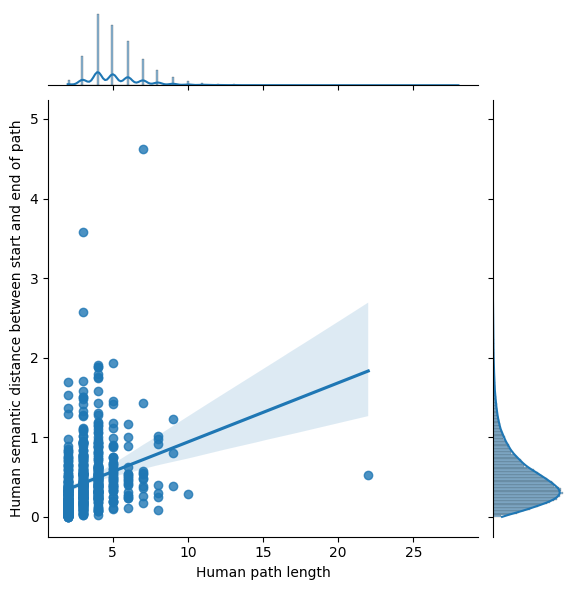

In [30]:
# Get the paths lengths indexed by the start and end pair
paths_len_humans_finished = pd.Series({ (path[0], path[-1]): len(path) for path in paths_finished_humans })
# Remove outliers
paths_len_humans_finished = paths_len_humans_finished[paths_len_humans_finished < 30]
distances_humans = distances_humans[distances_humans < 5]
# Plot path length against semantic distance between start and end
sns.jointplot(x=paths_len_humans_finished, y=distances_humans, kind='reg')
plt.xlabel('Human path length')
plt.ylabel('Human semantic distance between start and end of path')

In [31]:
# TODO compute Pearson and Spearman correlation coefficients
# TODO for this, we need to have series of the same length

Text(37.722222222222214, 0.5, 'LLM semantic distance between start and end of path')

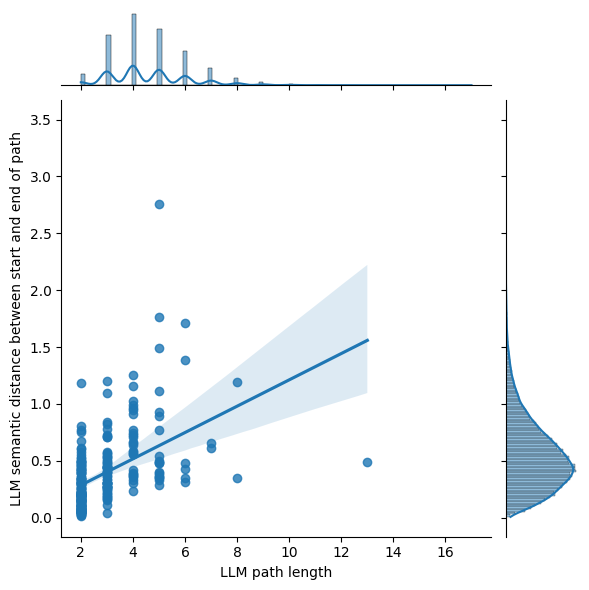

In [32]:
# Plot the same for LLM
series_paths_len_llm_finished = pd.Series({ (path[0], path[-1]): len(path) for path in paths_finished_llm_no_memory })
sns.jointplot(x=series_paths_len_llm_finished, y=distances_llm_no_memory, kind='reg')
plt.xlabel('LLM path length')
plt.ylabel('LLM semantic distance between start and end of path')

### Are humans or LLMs more deterministic in their choices?

We wanted to understand how much humans vs the LLM tend to make the same choice when they are several times placed on the same article with the same goal to reach. For this, we studied the distribution of the entropy for every pair (goal, current_article) that was encountered, by humans or by LLMs, and we plotted this distribution as a histogram.

0.04224662665718093, 1.3698959757739687e-48, interpretation: Different distributions


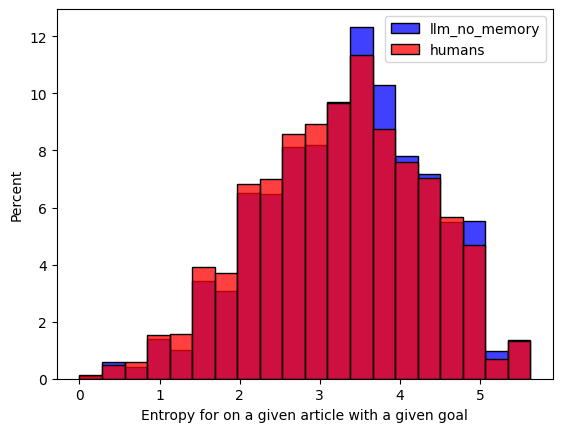

In [ ]:
def get_pairs_posterior_entropy(probs_posterior):
    pairs_entropies_posterior = dict()
    for g in probs_posterior:
        for a in probs_posterior[g]:
            pairs_entropies_posterior[(g, a)] = -sum([prob * np.log(prob) for prob in probs_posterior[g][a].values()])

    return pd.Series(pairs_entropies_posterior)

pairs_entropies_posterior_llm_no_memory = get_pairs_posterior_entropy(probs_posterior_llm_no_memory)
pairs_entropies_posterior_humans = get_pairs_posterior_entropy(probs_posterior_humans)

sns.histplot(pairs_entropies_posterior_llm_no_memory, color='blue', stat='percent', bins=20, label='llm_no_memory')
sns.histplot(pairs_entropies_posterior_humans, color='red', stat='percent', bins=20, label='humans')
plt.xlabel('Entropy for on a given article with a given goal')
plt.legend()

statistic, p_value = stats.ks_2samp(pairs_entropies_posterior_humans, pairs_entropies_posterior_llm_no_memory)
interpretation = 'Same distribution' if p_value > 0.05 else 'Different distributions'
print(f'{statistic}, {p_value}, interpretation: {interpretation}')

Here we see that when they are on a give article with a given goal in mind, the humans tend to make more predictable choices than the LLM. This is shown by the fact that the entropy of the probability distribution of which out-link is going to be clicked from a given article and with a given goal, this entropy tends to be lower for humans than for the LLM.

This tends to suggest that all the human players are together more consistent among themselves than the LLM is consistent with itself. and this despite the fact that humans on a given article with a given goal have the information of the previous articles they’ve already visited on this path, which could introduce variability in their choices, when the LLM only knows the current article, the start article and its goal when making its choice, which should tend to make it more deterministic. But we observe the opposite.

In [37]:
# describe the data

# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse


# Wikispeedia dataset exploration

Let's begin by exploring the Wikispeedia dataset. The dataset is composed of six files:
- articles.tsv, which contains the list of wikipedia articles
- categories.tsv, which contains the list of wikipedia categories
- links.tsv, which contains the list of links between articles
- paths_finished.tsv, which contains the list of human paths finished by the users
- paths_unfinished.tsv, which contains the list of human paths unfinished by the users
- shortest-path-distance-matrix.txt, which contains the shortest path distance between each pair of articles

In [38]:
# Load all the data from the tsv files, skipping the headers and specifying column names
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
articles = pd.read_csv(DATA_FOLDER + 'articles.tsv', sep='\t', skiprows=12, names=['article'])
categories = pd.read_csv(DATA_FOLDER + 'categories.tsv', sep='\t', skiprows=12, names=['article', 'category'])
links = pd.read_csv(DATA_FOLDER + 'links.tsv', sep='\t', skiprows=11, names=['linkSource', 'linkTarget'])
paths_finished = pd.read_csv(DATA_FOLDER + 'paths_finished.tsv', sep='\t', skiprows=15, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [39]:
# Decode the URL-encoded article titles
articles = articles.map(urllib.parse.unquote)
categories = categories.map(urllib.parse.unquote)
links = links.map(urllib.parse.unquote)
paths_finished['path'] = paths_finished['path'].map(urllib.parse.unquote)
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

### 1.a Articles 

Here, not much to describe, besides the number of articles.

In [40]:
# Count the articles
articles.count()

article    4604
dtype: int64

### 1.b Links

Let's play with the articles and links files to understand the structure of the dataset. On average, each article has 26 links to other articles. The United States article has the most outgoing (294) and incoming (1551) links. No article has no outgoing link nor is unreacheable.

In [41]:
# describe
print('-----Outgoing Links-----')
print(links['linkSource'].value_counts().describe())
print('-----Incoming Links-----')
print(links['linkTarget'].value_counts().describe())
links.describe()

-----Outgoing Links-----
count    4587.000000
mean       26.135165
std        24.194229
min         1.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
Name: count, dtype: float64
-----Incoming Links-----
count    4136.000000
mean       28.985010
std        65.554144
min         1.000000
25%         4.000000
50%        10.000000
75%        29.000000
max      1551.000000
Name: count, dtype: float64


,linkSource,linkTarget
count,119882,119882
unique,4587,4136
top,United_States,United_States
freq,294,1551


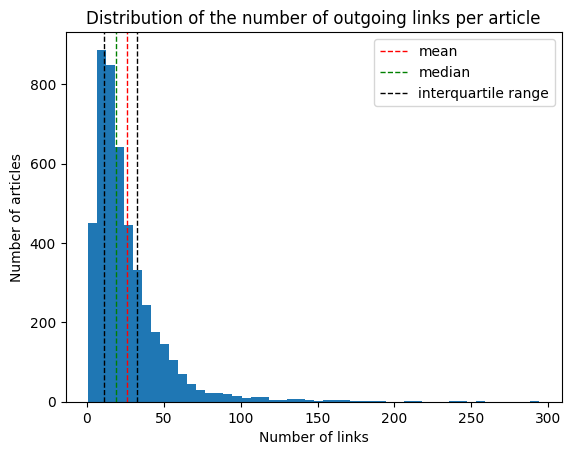

,linkTarget
count,4587.000000
mean,26.135165
std,24.194229
min,1.000000
25%,11.000000
50%,19.000000
75%,33.000000
max,294.000000


In [42]:

# plot the distribution of the number of links per article
links_per_article = links.groupby('linkSource').count()
links_per_article.hist(bins=50)
plt.title('Distribution of the number of outgoing links per article')
plt.xlabel('Number of links')
plt.ylabel('Number of articles')
# plot mean, median and interquartile range
plt.axvline(links_per_article.mean().values[0], color='r', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(links_per_article.median().values[0], color='g', linestyle='dashed', linewidth=1, label='median')
plt.axvline(links_per_article.quantile(0.25).values[0], color='black', linestyle='dashed', linewidth=1)
plt.axvline(links_per_article.quantile(0.75).values[0], color='black', linestyle='dashed', linewidth=1, label='interquartile range')
plt.legend()
plt.grid(False)
plt.show()

# get the mean, median, min and max number, std of links per article
links_per_article.describe()


The distribution is highly skewed to the right, with most articles having a relatively small number of outgoing links. The mean (26.1) is higher than the median (19).

Let's now plot the distribution of incoming links.

In [43]:
# get the number of incoming links for each article
# create a list of all articles that are linked to the article
links = links.groupby('linkSource')['linkTarget'].apply(list).reset_index(name='links')
incoming_links = []
for index, row in links.iterrows():
    for link in row['links']:
        incoming_links.append(link)
incoming_links = pd.Series(incoming_links)

incoming_links = incoming_links.value_counts()
incoming_links = incoming_links.reset_index()
incoming_links.columns = ['article', 'incoming_number']

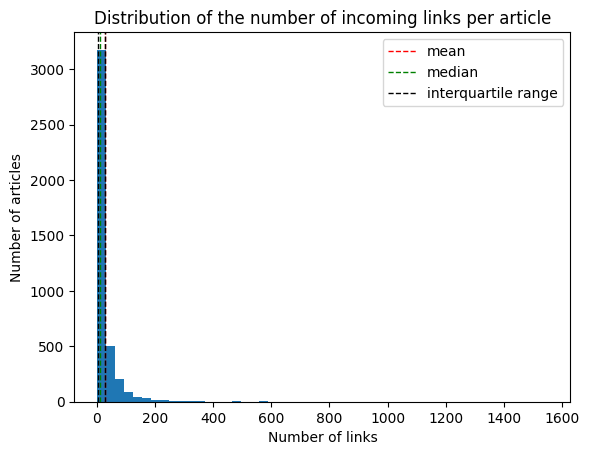

,incoming_number
count,4136.000000
mean,28.985010
std,65.554144
min,1.000000
25%,4.000000
50%,10.000000
75%,29.000000
max,1551.000000


In [44]:
incoming_links.hist(bins=50)
plt.title('Distribution of the number of incoming links per article')
plt.xlabel('Number of links')
plt.ylabel('Number of articles')
# plot mean, median and interquartile range
plt.axvline(incoming_links['incoming_number'].mean(), color='r', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(incoming_links['incoming_number'].median(), color='g', linestyle='dashed', linewidth=1, label='median')
plt.axvline(incoming_links['incoming_number'].quantile(0.25), color='black', linestyle='dashed', linewidth=1)
plt.axvline(incoming_links['incoming_number'].quantile(0.75), color='black', linestyle='dashed', linewidth=1, label='interquartile range')
plt.legend()
plt.grid(False)
plt.show()

# get the mean, median, min and max number, std of incoming links per article
incoming_links.describe()

Here, the distribution is closer to smaller values. However, there are stronger outliers, the mean (29) is way higher than the median (10)

We now want to look at a graph representation of articles.

In [ ]:
# creating a graph 
import networkx as nx


links = pd.read_csv(DATA_FOLDER + 'links.tsv', sep='\t', skiprows=11, names=['linkSource', 'linkTarget'])
# Decode the URL-encoded article titles
links = links.map(urllib.parse.unquote)

# Initialize directed graph
G = nx.DiGraph()
# creating a dataframe of edges
edges = links[['linkSource', 'linkTarget']]
# Add edges to the graph
G.add_edges_from(edges.values)  # Assuming edges is a DataFrame with columns [linksource, linktarget]

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 4593 nodes and 119882 edges.


The lower number of articles than previously stated seems to indicate that some articles are not present in the links data, which might be due to being not reachable.

In [47]:
# Nodes with in-degree < 10 (median)
low_in_degree_nodes = [node for node, in_degree in G.in_degree() if in_degree < 10]

# Nodes with out-degree < 19 (median)
low_out_degree_nodes = [node for node, out_degree in G.out_degree() if out_degree < 19]

# Nodes with total degree < 30 (sum of both medians)
low_total_degree_nodes = [node for node, degree in G.degree() if degree < 30]

print("Nodes with in-degree less than the median (10):", low_in_degree_nodes)
print("Nodes with out-degree less than the median (19):", low_out_degree_nodes)
print("Nodes with total degree less than both medians (30):", low_total_degree_nodes)


Nodes with in-degree less than the median (10): ['Áedán_mac_Gabráin', 'Åland', 'Édouard_Manet', 'Absinthe', 'Diego_Velázquez', 'Francisco_Goya', 'Éire', 'Óengus_I_of_the_Picts', '€2_commemorative_coins', 'Cathedral_of_Magdeburg', 'Numismatics', 'Sanssouci', 'Great_Moravia', 'Leif_Ericson', 'Macbeth_of_Scotland', 'Norman_conquest_of_England', 'Angkor_Wat', 'Francis_of_Assisi', 'Second_Crusade', 'The_Anarchy', 'Abacus', "English_peasants'_revolt_of_1381", 'Ibn_Battuta', '15th_Marine_Expeditionary_Unit', 'Kuwait_City', 'Mogadishu', 'Mount_Pinatubo', 'Royal_Marines', 'Battle_of_Grunwald', 'Joan_of_Arc', 'Johannes_Ockeghem', 'Zheng_He', '16_Cygni', '16_Cygni_Bb', 'Ivan_IV_of_Russia', 'Jacques_Cartier', 'Juan_Sebastián_Elcano', 'Spanish_conquest_of_the_Inca_Empire', 'Suleiman_the_Magnificent', 'William_the_Silent', '1755_Lisbon_earthquake', 'Armand_Jean_du_Plessis,_Cardinal_Richelieu', 'Philosophiae_Naturalis_Principia_Mathematica', 'William_Harvey', '1896_Summer_Olympics', 'Catherine_II_of_

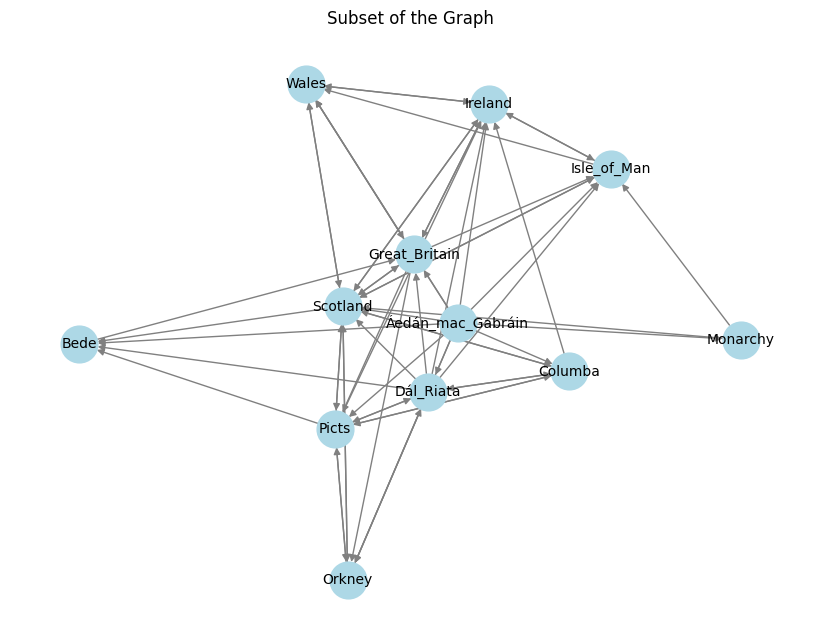

In [48]:
# Get neighbors of a specific node (e.g., the first one in the list)
node_of_interest = low_total_degree_nodes[0]
neighbors = list(G.successors(node_of_interest)) + [node_of_interest]

# Create a subgraph from the selected nodes
subgraph = G.subgraph(neighbors)

# Draw the subgraph
plt.figure(figsize=(8, 6))
nx.draw(
    subgraph,
    with_labels=True,
    node_size=700,
    node_color="lightblue",
    font_size=10,
    edge_color="gray",
)
plt.title("Subset of the Graph")
plt.show()


In [49]:
# get the 5 articles with the highest in-degree
in_degrees = G.in_degree()

# Sort the articles by in-degree
sorted_in_degrees = sorted(in_degrees, key=lambda x: x[1], reverse=True)

# Get the top 5 articles with the highest in-degree
top_5_in_degrees = sorted_in_degrees[:5]

# Print the top 5 articles with the highest in-degree
for article, in_degree in top_5_in_degrees:
    print(f"Article: {article}, In-degree: {in_degree}")

Article: United_States, In-degree: 1551
Article: United_Kingdom, In-degree: 972
Article: France, In-degree: 959
Article: Europe, In-degree: 933
Article: World_War_II, In-degree: 751


In [50]:
# get the 5 articles with the highest out-degree
out_degrees = G.out_degree()

# Sort the articles by out-degree
sorted_out_degrees = sorted(out_degrees, key=lambda x: x[1], reverse=True)

# Get the top 5 articles with the highest out-degree
top_5_out_degrees = sorted_out_degrees[:5]

# Print the top 5 articles with the highest out-degree
for article, out_degree in top_5_out_degrees:
    print(f"Article: {article}, Out-degree: {out_degree}")

Article: United_States, Out-degree: 294
Article: Driving_on_the_left_or_right, Out-degree: 255
Article: List_of_countries, Out-degree: 244
Article: List_of_circulating_currencies, Out-degree: 236
Article: List_of_sovereign_states, Out-degree: 216


### 1.c Categories

We also have access to the categories of the articles. Each article belongs to one or more categories. There is 129 different categories. Articles have at most 3 categories. The average number of categories per article is 1.1.

In [51]:
categories.describe()

,article,category
count,5204,5204
unique,4598,129
top,Pottery,subject.Countries
freq,3,229


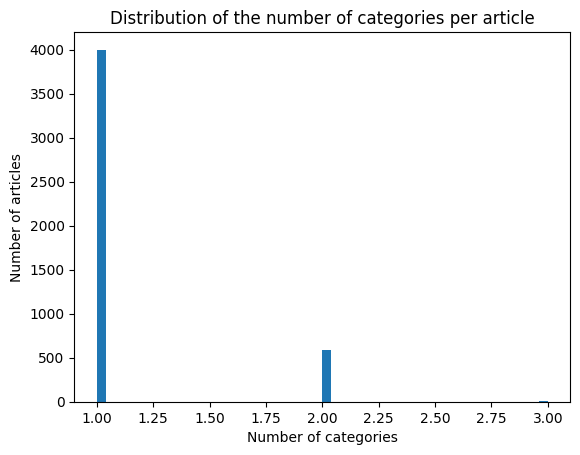

In [52]:
# plot the distribution of the number of categories per article
categories_per_article = categories.groupby('article').count()
categories_per_article.hist(bins=50)
plt.title('Distribution of the number of categories per article')
plt.xlabel('Number of categories')
plt.ylabel('Number of articles')
plt.grid(False)
plt.show()

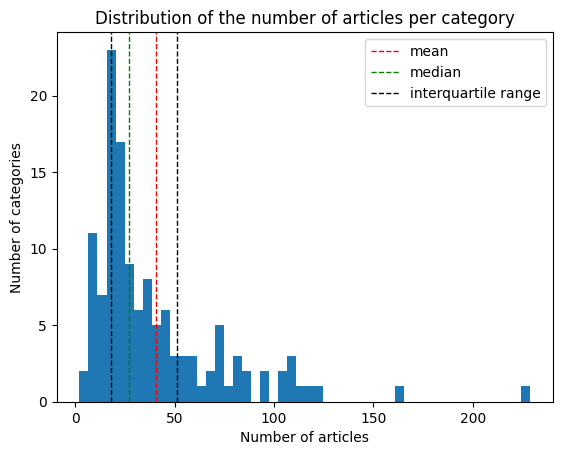

,article
count,129.000000
mean,40.341085
std,34.678095
min,2.000000
25%,18.000000
50%,27.000000
75%,51.000000
max,229.000000


In [53]:
# plot the distribution of the number of articles per category
articles_per_category = categories.groupby('category').count()
articles_per_category.hist(bins=50)
plt.title('Distribution of the number of articles per category')
plt.xlabel('Number of articles')
plt.ylabel('Number of categories')
plt.grid(False)

# plot mean, median and interquartile range
plt.axvline(articles_per_category.mean().values[0], color='r', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(articles_per_category.median().values[0], color='g', linestyle='dashed', linewidth=1, label='median')
plt.axvline(articles_per_category.quantile(0.25).values[0], color='black', linestyle='dashed', linewidth=1)
plt.axvline(articles_per_category.quantile(0.75).values[0], color='black', linestyle='dashed', linewidth=1, label='interquartile range')
plt.legend()
plt.show()

articles_per_category.describe()

Here, we can clearly see that categories are not at all evenly distributed amongst the dataset, this might be useful in later analysis.

### 1.d Paths Finished

We have access to a lot of paths! There are 51318 finished paths. However, the same path was completed many times, we are more interested in unique paths. We hence processed the data so that it only contain a given pair of start and goal articles at most once (chosen at random). This gives us a total of 28718 unique paths. 

In [54]:
paths_finished.describe()

,timestamp,durationInSec,rating
count,5.131800e+04,51318.000000,28501.000000
mean,1.296384e+09,158.276199,2.269780
std,4.935086e+07,360.841904,1.110439
min,1.219095e+09,0.000000,1.000000
25%,1.250109e+09,60.000000,1.000000
50%,1.283894e+09,107.000000,2.000000
75%,1.345231e+09,183.000000,3.000000
max,1.389823e+09,35091.000000,5.000000


In [55]:
# get the number of unique path finished using unique path_id
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t', skiprows=1, names=['path_id', 'hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
print('Number of rows in paths_finished:', paths_finished.shape[0])

Number of rows in paths_finished: 28718


The average path length is 5.7 steps. The shortest path is 0 steps long (which indicate that the player started on the goal article) and the longest is 434 steps. The player was probably bored at this point. 

count    28718.000000
mean         5.672749
std          5.017178
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

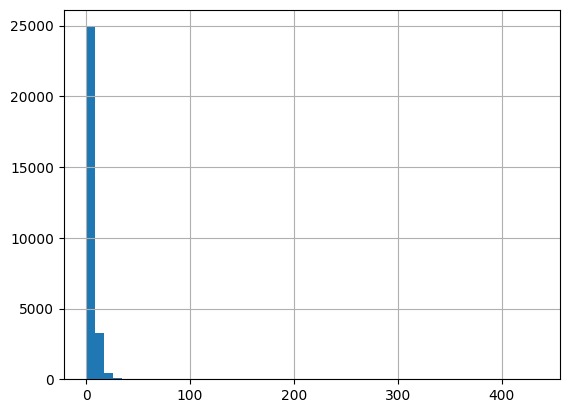

In [56]:
# get the number of steps in the finished paths
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].hist(bins=50)
paths_finished['path_length'].describe()

In [57]:
# get the paths with the longest path length
longest_paths = paths_finished.sort_values(by='path_length', ascending=False)
# get the pair of start and end articles
longest_paths['start'] = longest_paths['path'].apply(lambda x: x.split(';')[0])
longest_paths['end'] = longest_paths['path'].apply(lambda x: x.split(';')[-1])
# get the top 5 longest paths
longest_paths.head()


,path_id,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,start,end
26842,26842,7f6da01d55086766,1248928447,2205,United_States;Washington%2C_D.C.;Government;Co...,5.0,434,United_States,English_language
18090,18090,4f1b9ce764349901,1236685130,2292,Napoleon_I_of_France;United_Kingdom;Great_Brit...,NaN,118,Napoleon_I_of_France,Recycling
20612,20612,4e97d9af4476607f,1248925083,1141,Police_state;Police;United_States;Washington%2...,5.0,103,Police_state,African_slave_trade
15060,15060,0d57c8c57d75e2f5,1290096241,1852,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,5.0,98,Lake_Toba,Looney_Tunes
7495,7495,6616bb9562890cb9,1222830740,971,David_Beckham;Munich;Onion_dome;Onion;Plant;He...,4.0,85,David_Beckham,Sorrel


Funny to see that the longest path was between two seemingly close notions: US and English language

In [58]:
print(paths_finished.head())

   path_id   hashedIpAddress   timestamp  durationInSec  \
0        0  651ff0fa4fac4471  1227628729             15   
1        1  516b61133d358ce1  1224623308              6   
2        2  32652d6d1c5d9351  1260397548             48   
3        3  0d57c8c57d75e2f5  1296192247             15   
4        4  40111bc7370e59f5  1250228731             92   

                                                path  rating  path_length  
0   %E2%82%AC2_commemorative_coins;Ireland;Irish_Sea     1.0            2  
1                          10th_century;11th_century     1.0            1  
2  10th_century;Maya_civilization;Silver;Coin;Ban...     3.0            4  
3                       10th_century;Germany;Country     1.0            2  
4  10th_century;France;United_States;Basketball;H...     2.0            4  


Do people take a long time to finish the game? The average time is 161 seconds, i.e., 2min 40 s. The longest time is 35091 s, that is 9h 58min 21s. The shortest time is 0 s, i.e., the player was immediately done. Most of the players (75th percentile) took less than 3 minutes, 3 seconds to finish the game.

In [59]:
paths_finished['durationInSec'].describe()


count    28718.000000
mean       161.745386
std        388.877407
min          0.000000
25%         58.000000
50%        105.000000
75%        184.000000
max      35091.000000
Name: durationInSec, dtype: float64

In [60]:
# get the path with the longest duration
longest_duration = paths_finished.sort_values(by='durationInSec', ascending=False)
longest_duration.head()
# print the path with the longest duration
print('Longest duration path:', longest_duration.iloc[0])

Longest duration path: path_id                                                        18718
hashedIpAddress                                     3c623ddc539a389a
timestamp                                                 1262371920
durationInSec                                                  35091
path               Norse_mythology;Literature;Fiction;Computer_an...
rating                                                           NaN
path_length                                                        7
Name: 18718, dtype: object


The longest path in time duration is not even the longest one in path_length!

Let's look at the shortest durations now

In [61]:
shortest_duration = paths_finished.sort_values(by='durationInSec', ascending=True)
shortest_duration.head()
# print the path with the longest duration
print('Shortest duration path:', shortest_duration.iloc[0])

Shortest duration path: path_id                       28186
hashedIpAddress    43f864c75b2571b5
timestamp                1350587414
durationInSec                     0
path               William_and_Mary
rating                          NaN
path_length                       0
Name: 28186, dtype: object


This seems like an example of the player arriving directly at its destination

We now look at the number of steps in the finished paths and the duration in seconds, to look if we can see similarities or correlations.

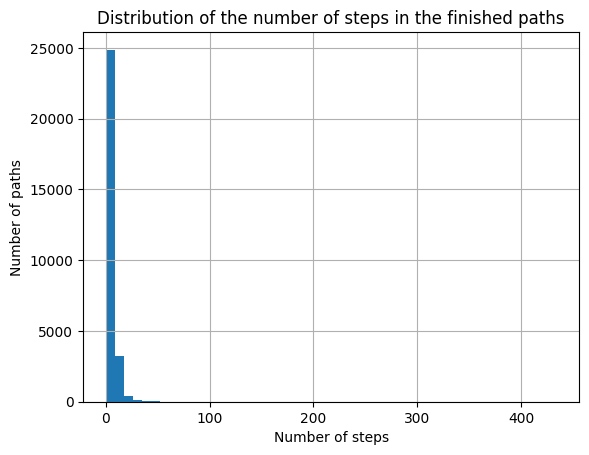

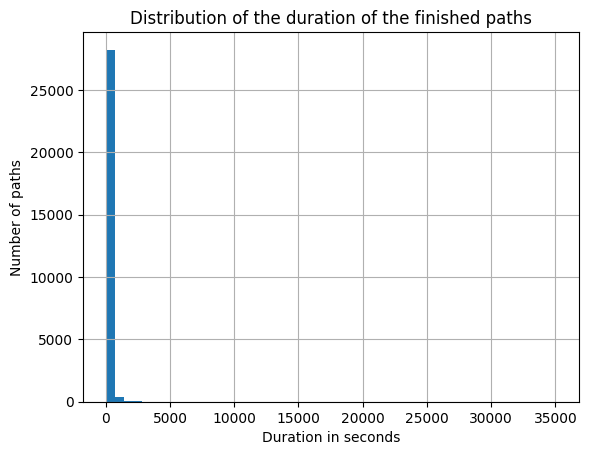

In [62]:
# plot the distribution of the number of steps in the finished paths
paths_finished['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

# plot the distribution of the duration of the finished paths
paths_finished['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the finished paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()




Not going further into the duration exploration, as it will not be necessary for our story.

Let's look at the distribution of steps, we look at less than the 98th percentile to dismiss outliers.

In [63]:
# get the 98th percentile of the number of steps in the finished paths
paths_finished['path_length'].quantile(0.98)

18.0

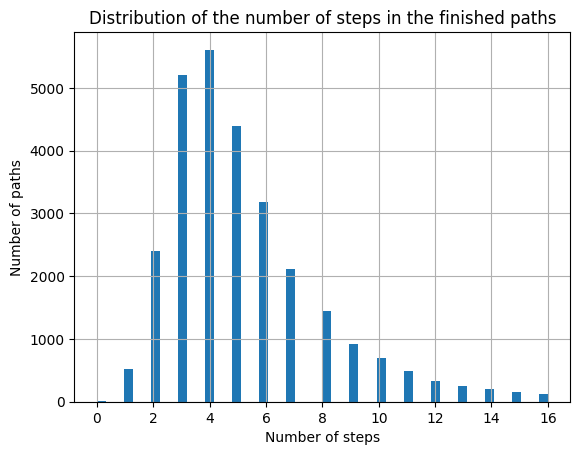

In [64]:
# drop the rows with number of steps > 18
paths_finished_lt_18 = paths_finished[paths_finished['path_length'] < 17]

# plot the distribution of the number of steps in the finished paths
paths_finished_lt_18['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

Let's now look at the ratings! It is not mandatory to give a rating. Are paths in the dataset considered easier or harder on average?

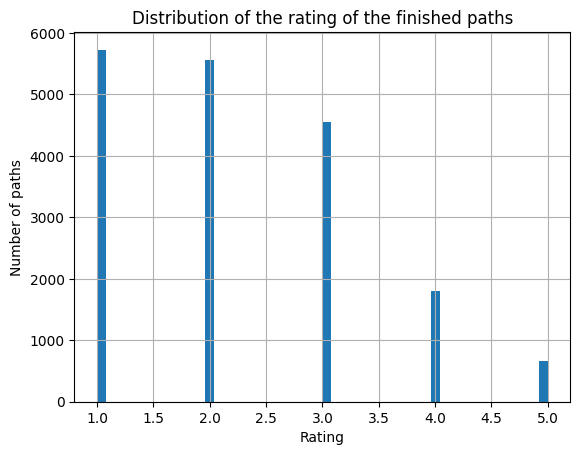

count    18287.000000
mean         2.240280
std          1.105805
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rating, dtype: float64

In [65]:
# plot the distribution of the rating of the finished paths
paths_finished['rating'].hist(bins=50)
plt.title('Distribution of the rating of the finished paths')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.show()

paths_finished['rating'].describe()

The average is at 2.27 (around the mid value possible for the ratings) and the median is at 2. Overall the paths seem to be rated easier than harder

In [66]:
# for each row add a column containing the pair of the first and last article in the path
paths_finished['pair'] = paths_finished['path'].apply(lambda x: x.split(';')[0] + ' -> ' + x.split(';')[-1])

print(paths_finished.head())

   path_id   hashedIpAddress   timestamp  durationInSec  \
0        0  651ff0fa4fac4471  1227628729             15   
1        1  516b61133d358ce1  1224623308              6   
2        2  32652d6d1c5d9351  1260397548             48   
3        3  0d57c8c57d75e2f5  1296192247             15   
4        4  40111bc7370e59f5  1250228731             92   

                                                path  rating  path_length  \
0   %E2%82%AC2_commemorative_coins;Ireland;Irish_Sea     1.0            2   
1                          10th_century;11th_century     1.0            1   
2  10th_century;Maya_civilization;Silver;Coin;Ban...     3.0            4   
3                       10th_century;Germany;Country     1.0            2   
4  10th_century;France;United_States;Basketball;H...     2.0            4   

                                          pair  
0  %E2%82%AC2_commemorative_coins -> Irish_Sea  
1                 10th_century -> 11th_century  
2                     10th_century 

We're interested in seeing if the rating is correlated with the number of steps taken.

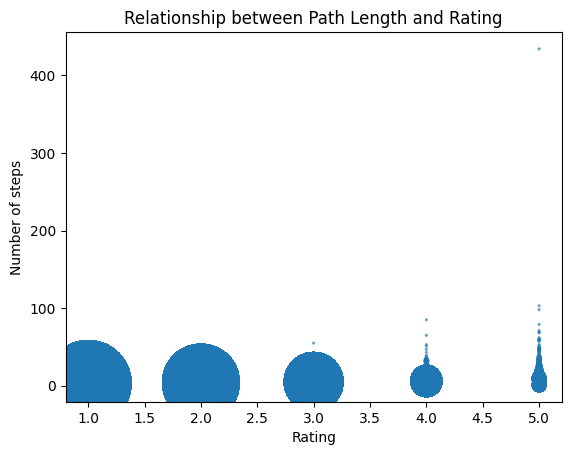

In [67]:
# Calculate the path length for each finished path
paths_finished_with_ratings = paths_finished.dropna(subset=['rating'])
point_sizes = paths_finished_with_ratings.groupby(['rating', 'path_length']).size().reset_index(name='counts')
merged_data = pd.merge(paths_finished_with_ratings, point_sizes, on=['rating', 'path_length'])
# Plot the relationship between rating and path length as a bar plot with inverted axes
plt.scatter(merged_data['rating'], merged_data['path_length'], s=merged_data['counts']*2, alpha=0.5)
plt.ylabel('Number of steps')
plt.xlabel('Rating')
plt.title('Relationship between Path Length and Rating')
plt.show()

Here, it seems complicated to see any relationship. However, let's try statistical tests to see if there is any relationship between the rating and the path length.

In [68]:
# Compute the correlation between rating and path length using scipy
from scipy.stats import pearsonr, spearmanr

# Calculate the Pearson correlation coefficient and its p-value
pearson_corr, pearson_p_value = pearsonr(paths_finished_with_ratings['rating'], paths_finished_with_ratings['path_length'])
print(f"Pearson Correlation Coefficient: {pearson_corr}, p-value: {pearson_p_value}")

# Calculate the Spearman correlation
spearman_corr, spearman_p_value = spearmanr(paths_finished_with_ratings['rating'], paths_finished_with_ratings['path_length'])
print(f"Spearman Correlation Coefficient: {spearman_corr}, p-value: {spearman_p_value}")


Pearson Correlation Coefficient: 0.41156854924009395, p-value: 0.0
Spearman Correlation Coefficient: 0.5918271303966154, p-value: 0.0


It seems the correlation is real. However, it might be caused by outliers. Let's try removing them by taking up to a given outlier (80%).

In [69]:
# same correlation computation but discarding outliers (paths under the 80th percentile)
q80 = paths_finished['path_length'].quantile(0.8)
paths_finished_under80_with_ratings = paths_finished[paths_finished['path_length'] < q80].dropna(subset=['rating'])
pearson_corr, pearson_p_value = pearsonr(paths_finished_under80_with_ratings['rating'], paths_finished_under80_with_ratings['path_length'])
print(f"Pearson Correlation Coefficient (without outliers): {pearson_corr}, p-value: {pearson_p_value}")
spearman_corr, spearman_p_value = spearmanr(paths_finished_under80_with_ratings['rating'], paths_finished_under80_with_ratings['path_length'])
print(f"Spearman Correlation Coefficient (without outliers): {spearman_corr}, p-value: {spearman_p_value}")


Pearson Correlation Coefficient (without outliers): 0.41903827049101117, p-value: 0.0
Spearman Correlation Coefficient (without outliers): 0.46947593405371385, p-value: 0.0


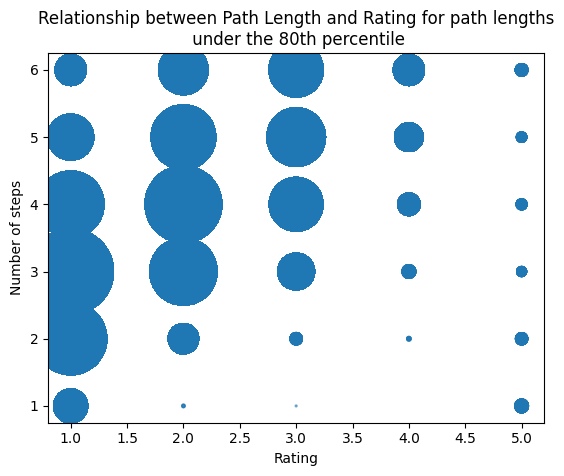

In [115]:
# Calculate the size of the points based on the number of occurrences
point_sizes = paths_finished_under80_with_ratings.groupby(['rating', 'path_length']).size().reset_index(name='counts')
merged_data = pd.merge(paths_finished_under80_with_ratings, point_sizes, on=['rating', 'path_length'])

plt.scatter(merged_data['rating'], merged_data['path_length'], s=merged_data['counts']*2, alpha=0.5)
plt.ylabel('Number of steps')
plt.xlabel('Rating')
plt.title('Relationship between Path Length and Rating for path lengths\n under the 80th percentile')
plt.show()

Even though visibly this might not be clear, we still find a positive correlation between number of steps taken and the rating. This means we can affirm paths considered harder by players are usually longer to complete.

### 1.e Paths Unfinished

For different reasons, some people did not finish the game. There are 24875 unfinished paths. The average path length is 4.2, with a median at 3. 

In [116]:
paths_unfinished.describe()

,timestamp,durationInSec
count,2.487500e+04,24875.000000
mean,1.344763e+09,835.296884
std,2.772317e+07,881.287961
min,1.297055e+09,4.000000
25%,1.320339e+09,86.000000
50%,1.348587e+09,261.000000
75%,1.367373e+09,1831.000000
max,1.389823e+09,9089.000000


In [117]:
# compute number of steps
paths_unfinished['path_length'] = paths_unfinished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_unfinished['path_length'].describe()

count    24875.000000
mean         4.197789
std          5.772234
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        234.000000
Name: path_length, dtype: float64

In [118]:
# for each row add a column containing the pair of the first article in the path and the target article
paths_unfinished['pair'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0]) + ' -> ' + paths_unfinished['target']

print(paths_unfinished.head())

    hashedIpAddress   timestamp  durationInSec  \
0  2426091a53125110  1297054935           1804   
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
3  53a53bc244e08a6a  1297094761             49   
4  53a53bc244e08a6a  1297099105           1808   

                                   path            target     type  \
0                        Obi-Wan_Kenobi         Microsoft  timeout   
1                         Julius_Caesar           Caracas  timeout   
2  Malawi;Democracy;Alexander_the_Great     First_Crusade  timeout   
3                              Paraguay  Mount_St._Helens  restart   
4                      Paraguay;Bolivia  Mount_St._Helens  timeout   

                           pair  path_length  
0   Obi-Wan_Kenobi -> Microsoft            0  
1      Julius_Caesar -> Caracas            0  
2       Malawi -> First_Crusade            2  
3  Paraguay -> Mount_St._Helens            0  
4  Paraguay -> Mount_St._Helens            

In [119]:
# get the number of unique path unfinished using unique path_id
paths_unfinished_unique = paths_unfinished.drop_duplicates(subset='pair')

print('Number of rows with unique source and target, in paths_unfinished:', paths_unfinished_unique.shape[0])

Number of rows with unique source and target, in paths_unfinished: 18190


Let's look at some paths that some users finished and some that they did not finish. There are 4199 common paths between the finished and unfinished paths. 

In [120]:
# compare the finished pairs with the unfinished pairs and get the number of common pairs
common_pairs = paths_finished['pair'].isin(paths_unfinished['pair'])

print(common_pairs.sum())

4199


It's interesting to see that the average rating of the common pair is 2,7. It's higher than the average rating of the finished paths (2,27). We can contrast the fact that the distribution of ratings is decreasing for finished paths but concave for unfinished paths.

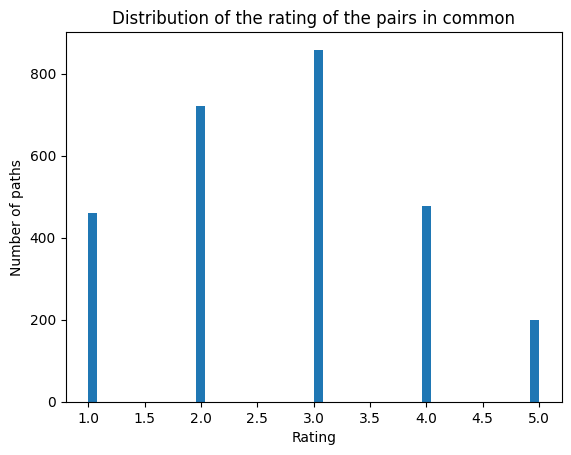

count    2714.000000
mean        2.716654
std         1.154345
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: rating, dtype: float64

In [121]:
# get the distribution of the rating of the common pairs

common_pairs_rating = paths_finished[paths_finished['pair'].isin(paths_unfinished['pair'])]['rating']
common_pairs_rating.hist(bins=50)
plt.title('Distribution of the rating of the pairs in common')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.grid(False)
plt.show()

common_pairs_rating.describe()


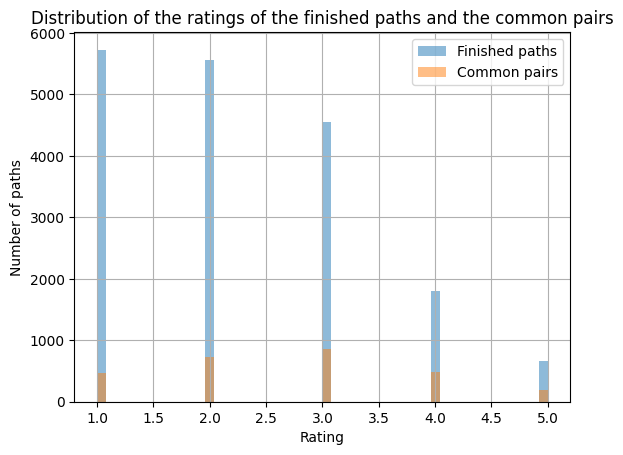

In [122]:
# compare the distribution of the ratings of the finished paths and the common pairs normalized by the number of paths
paths_finished['rating'].hist(bins=50, alpha=0.5, label='Finished paths')
common_pairs_rating.hist(bins=50, alpha=0.5, label='Common pairs')
plt.title('Distribution of the ratings of the finished paths and the common pairs')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.legend()
plt.show()


Look at the distribution of the duration of the unfinished paths. It seems that we have 2 plots. The first one corresponds to the duration less than 30min. The second one corresponds to the duration greater than 30min. The first correspond to the paths that end with a restart and the second one to the paths that end with a give up or timeout.

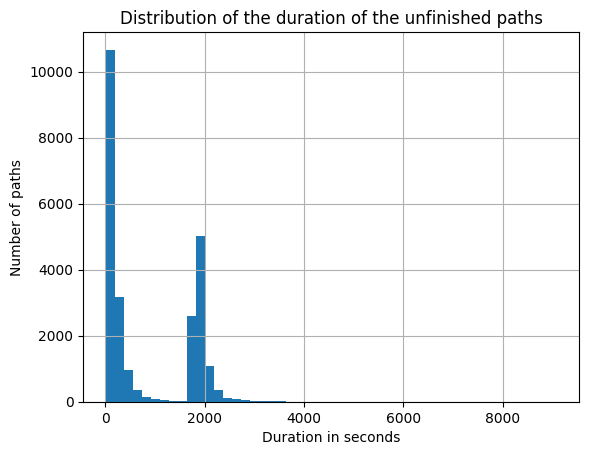

In [123]:
# plot the distribution of the duration of the unfinished paths
paths_unfinished['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the unfinished paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()

In [124]:
# get the 98th percentile of the duration of the unfinished paths
paths_unfinished['durationInSec'].quantile(0.98)

2262.0

We now plot under the 98th percentile to give a clearer view

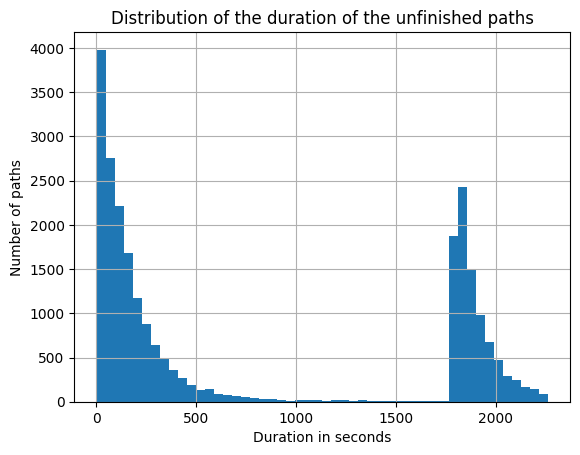

In [125]:
# drop the rows with durationInSec > 2262
paths_unfinished = paths_unfinished[paths_unfinished['durationInSec'] < 2262]

# plot the distribution of the duration of the unfinished paths
paths_unfinished['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the unfinished paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()

Let's confirm that previous hypothesis by splitting both graphs

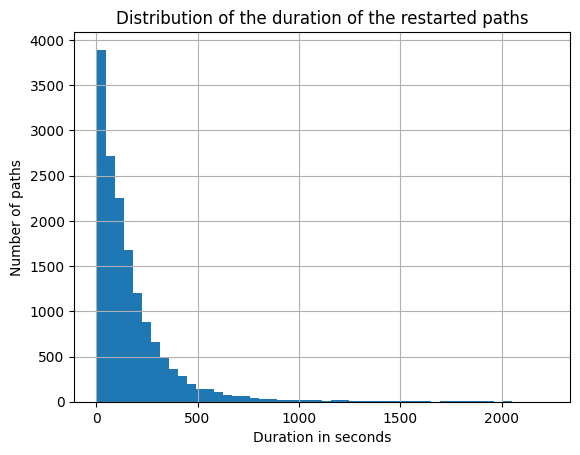

In [126]:
# plot the distribution of the duration of the restarted paths
paths_unfinished[paths_unfinished['type'] == 'restart']['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the restarted paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()

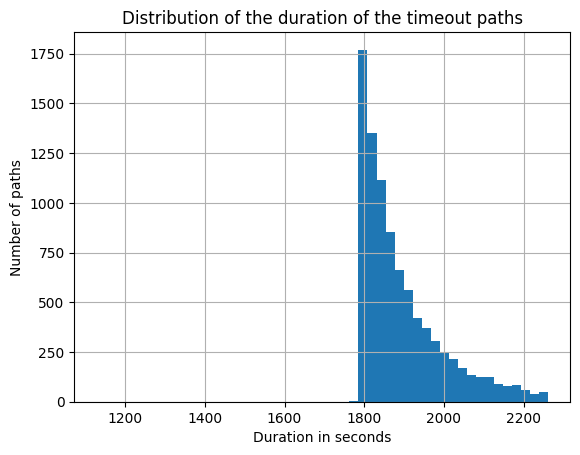

In [127]:
# plot the distribution of the duration of the timeout paths
paths_unfinished[paths_unfinished['type'] == 'timeout']['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the timeout paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()


Indeed, it is two distinct graphs! Timeouts are longer (start around 1800s, i.e. 30 minutes)

Why don't people finish paths? Let's look deeper into that: 65% restart, 35% let the game timeout.

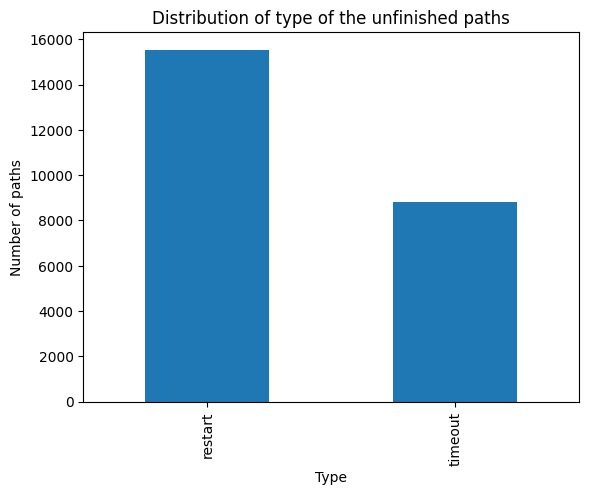

In [128]:
# plot the distribution of type of the unfinished paths
paths_unfinished['type'].value_counts().plot(kind='bar')
plt.title('Distribution of type of the unfinished paths')
plt.xlabel('Type')
plt.ylabel('Number of paths')
plt.show()

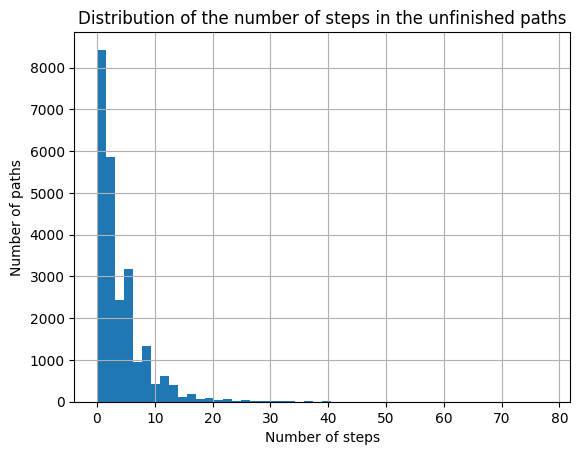

In [129]:
# plot the distribution of the number of steps in the unfinished paths
paths_unfinished['path_length'] = paths_unfinished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_unfinished['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the unfinished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

On average, the paths that end with a restart have a higher number of steps than the timeout. We cannot conclude anything particular about that as there are no particular reason why a player restarts or timeout the game.

In [130]:
# describe the data
paths_unfinished[paths_unfinished['type'] == 'restart']['path_length'].describe()

count    15546.000000
mean         4.227904
std          5.079880
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         78.000000
Name: path_length, dtype: float64

In [131]:
paths_unfinished[paths_unfinished['type'] == 'timeout']['path_length'].describe()

count    8830.000000
mean        3.344281
std         3.802274
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        66.000000
Name: path_length, dtype: float64

### Comparing llm and human paths

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns

## Path with no memory

In [133]:
# load the data data/llm_paths_all_gpt4omini_no_memory.tsv
llm_paths_all_gpt4omini_no_memory = pd.read_csv('data/llm_paths_all_gpt4omini_no_memory.tsv', sep='\t')

1. Does the llm take on average more steps than the human?

In [134]:
# As we created the data, we made the number of steps to be 0 if the path was unsuccessful. For this analysis, we will filter out the rows with 0 steps.
# filter out the rows with 0 steps
llm_paths_all_gpt4omini_no_memory = llm_paths_all_gpt4omini_no_memory[llm_paths_all_gpt4omini_no_memory['steps'] > 0]
# describe the data
llm_paths_all_gpt4omini_no_memory['steps'].describe()

count    14527.000000
mean         3.661527
std          1.612817
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: steps, dtype: float64

In [135]:
# we will compare the llm to the human data so let's load the human data!
# load the data data/paths_finished_unique.tsv
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t')

# get the number of steps in the finished paths
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].describe()

count    28718.000000
mean         5.672749
std          5.017178
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

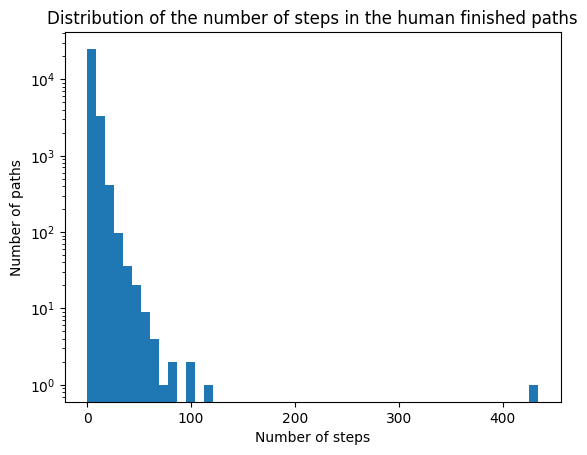

In [136]:
# plot the distribution of the number of steps in the finished paths
paths_finished['path_length'].hist(bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the human finished paths')
plt.grid(False)
plt.yscale('log')

In [137]:
# we created a column that contains the number of steps in the path. 
llm_paths_all_gpt4omini_no_memory['path_length'] = llm_paths_all_gpt4omini_no_memory['path'].apply(lambda x: len(x.split(';')) - 1)

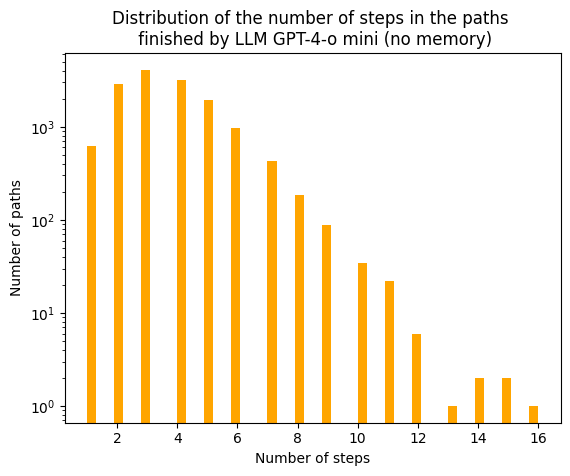

In [138]:
llm_paths_all_gpt4omini_no_memory['path_length'].hist(color='orange', bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the paths \n finished by LLM GPT-4-o mini (no memory)')
plt.grid(False)
plt.yscale('log')

In [139]:
# To have a good comparaison we wanted to take only the path_id that are in the 2 datasets
# create a mask using the past_id column
mask = paths_finished['path_id'].isin(llm_paths_all_gpt4omini_no_memory['path_id'])
paths_finished_filtered = paths_finished[mask]


# get the number of steps in the filtered paths
paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished_filtered['path_length'].describe()


/tmp/ipykernel_34802/1430737629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)


count    14527.000000
mean         4.747505
std          4.764334
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        434.000000
Name: path_length, dtype: float64

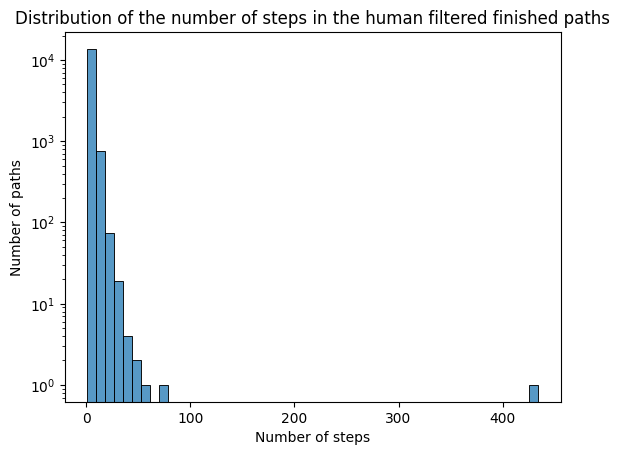

In [140]:
# plot the distribution of the number of steps in the filtered paths
sns.histplot(paths_finished_filtered['path_length'], bins=50)
plt.title('Distribution of the number of steps in the human filtered finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.yscale('log')

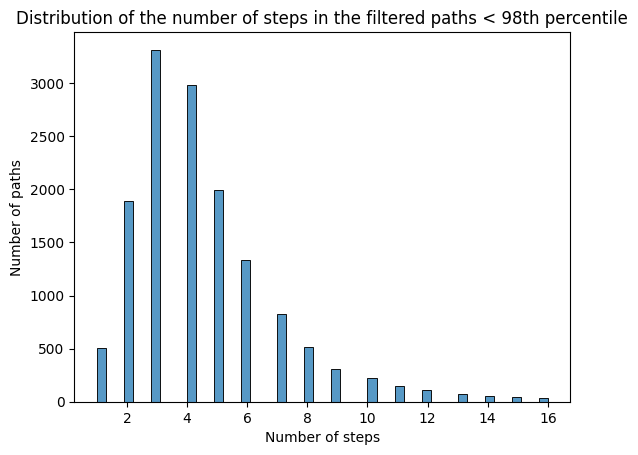

In [141]:
# We can easily identify outliers in the human dataset. Therefore we choose to get the 98th percentile of the number of steps in the filtered paths
percentile_99 = np.percentile(paths_finished_filtered['path_length'], 99)
# plot the distribution of the number of steps in the filtered paths that are less than the 98th percentile
paths_finished_filtered_lt_99 = paths_finished_filtered[paths_finished_filtered['path_length'] < percentile_99]
sns.histplot(paths_finished_filtered_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the filtered paths < 98th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

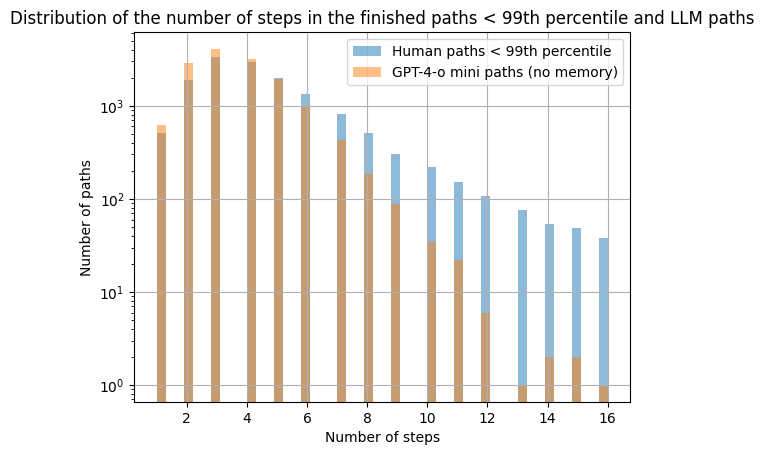

In [142]:
# compare the distribution of the number of steps in the finished paths filtered 99 percentile and the LLM paths
paths_finished_filtered_lt_99['path_length'].hist(bins=50, alpha=0.5, label='Human paths < 99th percentile')
llm_paths_all_gpt4omini_no_memory['path_length'].hist(bins=50, alpha=0.5, label='GPT-4-o mini paths (no memory)')
plt.title('Distribution of the number of steps in the finished paths < 99th percentile and LLM paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

2. How does the llm work for unfinished paths?

In [143]:
# load the data of unfinished paths
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

In [144]:
# for each row add a column containing the pair of the first article in the path and the target article
paths_unfinished['pair'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0]) + ' -> ' + paths_unfinished['target']
# create a subset of the data by taking only one ocurrence of each pair
paths_unfinished_unique = paths_unfinished.drop_duplicates(subset='pair')

In [145]:
# Now for the finished paths, we will do the same thing
# for each row add a column containing the pair of the first article in the path and the target article
paths_finished['pair'] = paths_finished['path'].apply(lambda x: x.split(';')[0] + ' -> ' + x.split(';')[-1])


In [146]:
# Some users fail a path that is succeed by another one. To avoid running the same path again, we will filter out the paths that are finished by some other user.
# get the paths_unfinished_unique that are not in the paths_finished_unique
mask = ~paths_unfinished_unique['pair'].isin(paths_finished['pair'])
paths_unfinished_unique_filtered = paths_unfinished_unique[mask]

print(paths_unfinished_unique_filtered.head())
# get the number of unique paths_unfinished_unique_filtered
print(paths_unfinished_unique_filtered['pair'].nunique())

# store the paths_unfinished_unique_filtered
paths_unfinished_unique_filtered.to_csv('data/paths_unfinished_unique_filtered.tsv', sep='\t', index=False)

    hashedIpAddress   timestamp  durationInSec  \
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
5  131600803df4895e  1297100557           2009   
6  486bb79910fe9dd2  1297101660           1932   
7  6d136e371e42474f  1297102070            175   

                                                path                target  \
1                                      Julius_Caesar               Caracas   
2               Malawi;Democracy;Alexander_the_Great         First_Crusade   
5  Agriculture;History_of_the_world;China;Yangtze...  Grand_Canal_of_China   
6  Mind;Christianity;Europe;Renaissance;Ancient_G...              Scouting   
7    4-2-0;United_States;Agriculture;Sugar;Australia             Cane_Toad   

      type                                 pair  
1  timeout             Julius_Caesar -> Caracas  
2  timeout              Malawi -> First_Crusade  
5  timeout  Agriculture -> Grand_Canal_of_China  
6  timeout                    

Percentage of loop detected  0.4484240687679083
Percentage of wrong answer  0.17765042979942694
Percentage of dead end  0.06876790830945559
Percentage of finished paths  0.30515759312320917


Text(0.5, 1.0, 'Outcome of the paths generated by LLM on unfinished paths by humans')

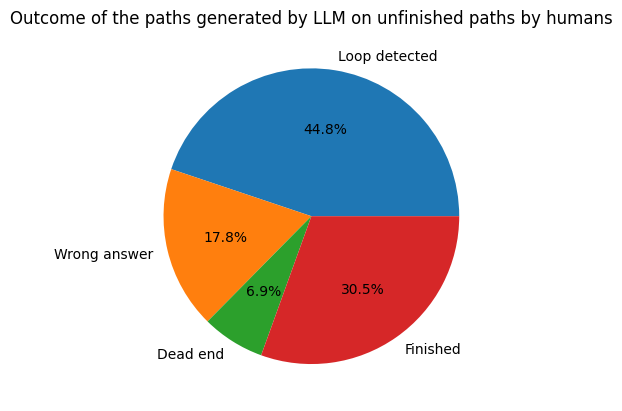

In [147]:
# After running the LLM on the paths_unfinished_unique_filtered, using a similar script as before (run_llm_games_unfinished.py), with the same prompt we get the data/llm_on_paths_unfinished.tsv
llm_paths_unfinished = pd.read_csv('data/llm_on_paths_unfinished.tsv', sep='\t')

# get the number of loop_detetected
# in the path column, if the last element is LOOP_DETECTED, then it is a loop
llm_paths_unfinished['loop_detected'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'LOOP_DETECTED')


# get the number of wrong_answer
# in the path column, if the last element is WRONG_ANSWER, then it is a wrong answer
llm_paths_unfinished['wrong_answer'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'WRONG_ANSWER')


# get the number of paths that goes to a link with dead end
# in the path column, if the last element is NO_LINK, then it is a dead end
llm_paths_unfinished['no_link'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'NO_LINK')

# get the number of paths that finishes i.e. there is no LOOP_DETECTED, WRONG_ANSWER or NO_LINK
llm_paths_unfinished['finished'] = ~(llm_paths_unfinished['loop_detected'] | llm_paths_unfinished['wrong_answer'] | llm_paths_unfinished['no_link'])



# print the percentage of each
print("Percentage of loop detected ",llm_paths_unfinished['loop_detected'].sum() / len(llm_paths_unfinished))
print("Percentage of wrong answer ",llm_paths_unfinished['wrong_answer'].sum() / len(llm_paths_unfinished))
print("Percentage of dead end ",llm_paths_unfinished['no_link'].sum() / len(llm_paths_unfinished))
print("Percentage of finished paths ",llm_paths_unfinished['finished'].sum() / len(llm_paths_unfinished))

labels = 'Loop detected', 'Wrong answer', 'Dead end', 'Finished'
sizes = [llm_paths_unfinished['loop_detected'].sum(), llm_paths_unfinished['wrong_answer'].sum(), llm_paths_unfinished['no_link'].sum(), llm_paths_unfinished['finished'].sum()]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Outcome of the paths generated by LLM on unfinished paths by humans')


In [148]:
# filter out the rows with 0 steps to filter the unfinished paths
llm_paths_unfinished = llm_paths_unfinished[llm_paths_unfinished['steps'] > 0]
# describe the data
llm_paths_unfinished['steps'].describe()

count    426.000000
mean       5.661972
std        3.545776
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       25.000000
Name: steps, dtype: float64

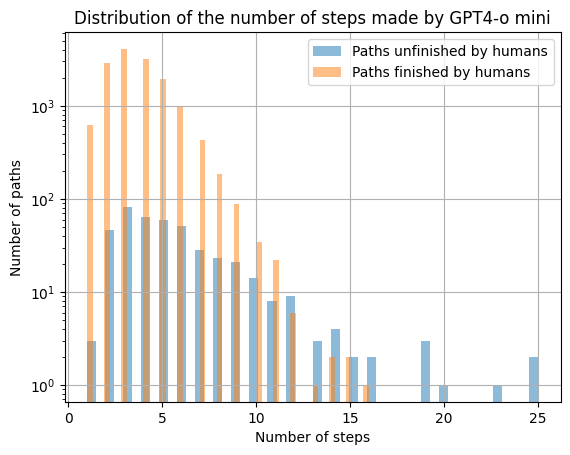

In [149]:
# we compare the number of steps of paths made by the llm by classifying them by the fact that the human finished or unfinished the corresponding path
llm_paths_unfinished['steps'].hist(bins=50, alpha=0.5, label='Paths unfinished by humans')
llm_paths_all_gpt4omini_no_memory['path_length'].hist(bins=50, alpha=0.5, label='Paths finished by humans')
plt.title('Distribution of the number of steps made by GPT4-o mini')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

3. What is the distribution of the categories of articles passed by the llm or by the human?

In [150]:
# We reload the data (it was modify to get only the successful paths)
# get the articles that llm goes to
llm_paths_all_gpt4omini_no_memory = pd.read_csv('data/llm_paths_all_gpt4omini_no_memory.tsv', sep='\t')
# get the categories of the articles
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)

In [151]:

# get the articles that human goes to
articles_llm = llm_paths_all_gpt4omini_no_memory['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_llm = [[item for item in sublist if item[0] != '<'] for sublist in articles_llm]

articles_llm = [item for sublist in articles_llm for item in sublist]
# get the categories of the articles
categories_of_articles_llm = []
for article in articles_llm:
    try:
        categories_of_articles_llm.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_llm = [item for sublist in categories_of_articles_llm for item in sublist]
categories_count_llm = pd.Series(categories_of_articles_llm).value_counts()

# print the 5 most common categories
print(categories_count_llm.head())
nbr = categories_count_llm.quantile(0.70)

subject.Countries                                          17316
subject.Science.Biology.General_Biology                     7016
subject.Geography.European_Geography.European_Countries     6374
subject.Geography.Geography_of_Great_Britain                5235
subject.Geography.North_American_Geography                  4791
Name: count, dtype: int64


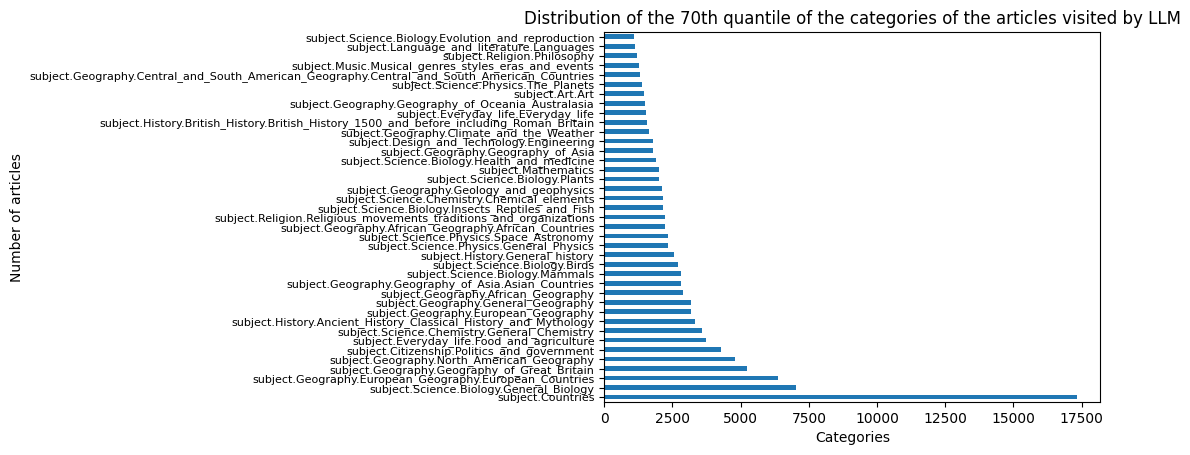

In [152]:
# plot the distribution of the 70th quantile to avoid outliers
categories_count_llm[categories_count_llm > nbr].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by LLM')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

In [153]:
# get the articles that human goes to
articles_human = paths_finished['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_human = [[item for item in sublist if item[0] != '<'] for sublist in articles_human]

articles_human = [item for sublist in articles_human for item in sublist]
# get the categories of the articles
categories_of_articles_human = []
for article in articles_human:
    try:
        categories_of_articles_human.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_human = [item for sublist in categories_of_articles_human for item in sublist]
categories_count_human = pd.Series(categories_of_articles_human).value_counts()

# print the 5 most common categories
print(categories_count_human.head())
nbr_h = categories_count_human.quantile(0.70)

subject.Countries                                          25739
subject.Geography.North_American_Geography                 10157
subject.Geography.European_Geography.European_Countries     9503
subject.Geography.Geography_of_Great_Britain                8169
subject.Geography.General_Geography                         6106
Name: count, dtype: int64


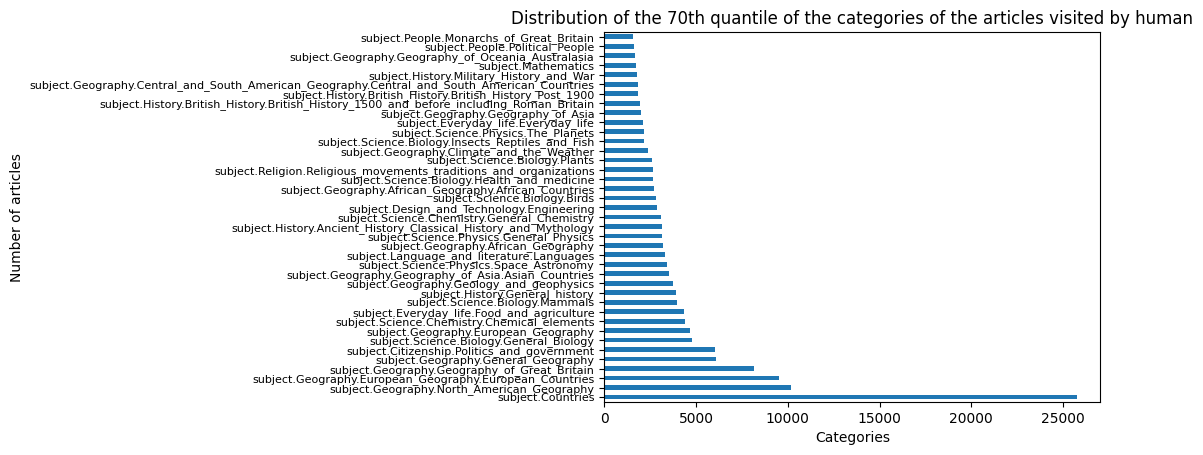

In [154]:
# plot the distribution of the 70th quantile
categories_count_human[categories_count_human > nbr_h].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by human')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

4. What is the distribution of the articles passed by the llm or by the human?

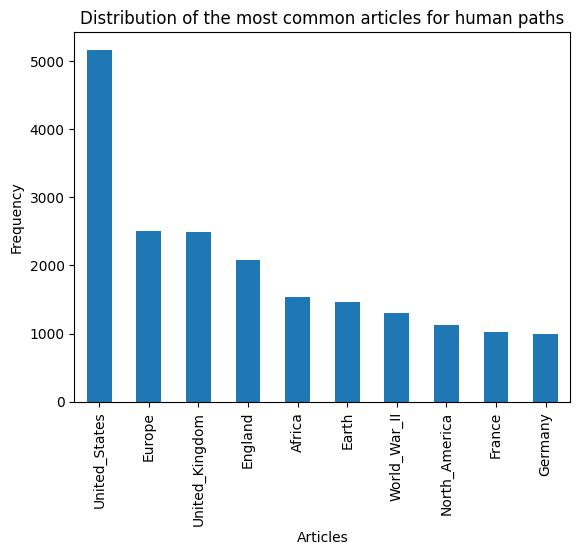

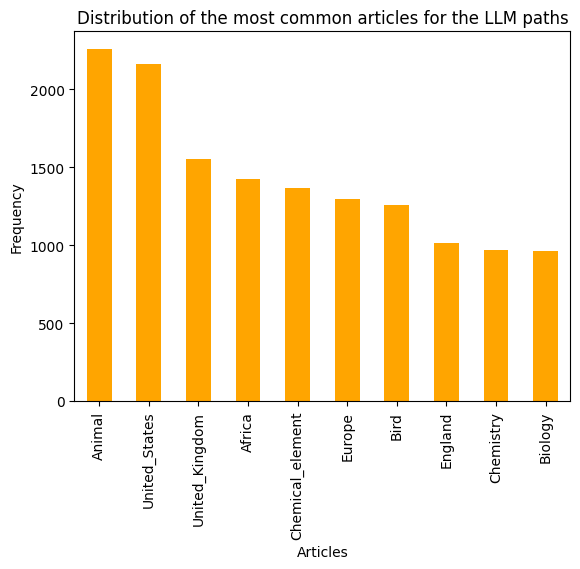

In [155]:

# Plot the distribution of the most common articles
articles_count_h = pd.Series(articles_human)
articles_count_h = articles_count_h.value_counts()
articles_count_h = articles_count_h.sort_values(ascending=False)
articles_count_h = articles_count_h[:10]
articles_count_h.plot(kind='bar')
plt.title('Distribution of the most common articles for human paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# from articles_llm, drop the loop_detected, wrong_answer and no_link
articles_llm = [item for item in articles_llm if item not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK']]


# Plot the distribution of the most common articles
articles_count = pd.Series(articles_llm)
articles_count = articles_count.value_counts()
articles_count = articles_count.sort_values(ascending=False)
articles_count = articles_count[:10]
articles_count.plot(kind='bar', color='orange')
plt.title('Distribution of the most common articles for the LLM paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()



In [156]:
# plot a comparison of the 10 most common articles of the llm and the human
print(articles_count_h)
print(articles_count)

print("the number of articles passes from human", articles_count_h.sum())
print(articles_count.sum())


United_States     5163
Europe            2502
United_Kingdom    2489
England           2073
Africa            1537
Earth             1456
World_War_II      1305
North_America     1128
France            1026
Germany            990
Name: count, dtype: int64
Animal              2259
United_States       2161
United_Kingdom      1553
Africa              1427
Chemical_element    1368
Europe              1295
Bird                1257
England             1013
Chemistry            968
Biology              966
Name: count, dtype: int64
the number of articles passes from human 19669
14267


Some info about the outgoing and incoming links of the two most common articles.

In [157]:
# we wanted to see if the links of each articles are correlated with the frequence of use
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', skiprows=12, names=['article', 'link'])
# group all links by their origin article
links = links.groupby('article')['link'].apply(list).reset_index(name='links')
links['outgoing_number']=links['links'].apply(lambda x: len(x))
print("The number of outgoing articles from the article 'United States':", links[links['article'] == 'United_States']['outgoing_number'].values[0])

The number of outgoing articles from the article 'United States': 294


In [158]:
print("The number of outgoing articles from the article 'Animal':", links[links['article'] == 'Animal']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'Europe':", links[links['article'] == 'Europe']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'United Kingdom':", links[links['article'] == 'United_Kingdom']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'England':", links[links['article'] == 'England']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'Africa':", links[links['article'] == 'Africa']['outgoing_number'].values[0])


The number of outgoing articles from the article 'Animal': 29
The number of outgoing articles from the article 'Europe': 159
The number of outgoing articles from the article 'United Kingdom': 168
The number of outgoing articles from the article 'England': 172
The number of outgoing articles from the article 'Africa': 212


In [159]:
# get the number of incoming links for each article
# create a list of all articles that are linked to the article
incoming_links = []
for index, row in links.iterrows():
    for link in row['links']:
        incoming_links.append(link)
incoming_links = pd.Series(incoming_links)

incoming_links = incoming_links.value_counts()
incoming_links = incoming_links.reset_index()
incoming_links.columns = ['article', 'incoming_number']
print("The number of incoming articles to the article 'United States':", incoming_links[incoming_links['article'] == 'United_States']['incoming_number'].values[0])

The number of incoming articles to the article 'United States': 1551


In [160]:
print("The number of incoming articles from the article 'Animal':", incoming_links[incoming_links['article'] == 'Animal']['incoming_number'].values[0])
print("The number of incoming articles from the article 'Europe':", incoming_links[incoming_links['article'] == 'Europe']['incoming_number'].values[0])
print("The number of incoming articles from the article 'United Kingdom':", incoming_links[incoming_links['article'] == 'United_Kingdom']['incoming_number'].values[0])
print("The number of incoming articles from the article 'England':", incoming_links[incoming_links['article'] == 'England']['incoming_number'].values[0])
print("The number of incoming articles from the article 'Africa':", incoming_links[incoming_links['article'] == 'Africa']['incoming_number'].values[0])
print("The number of incoming articles to the article 'Animal':", incoming_links[incoming_links['article'] == 'Animal']['incoming_number'].values[0])

The number of incoming articles from the article 'Animal': 492
The number of incoming articles from the article 'Europe': 933
The number of incoming articles from the article 'United Kingdom': 972
The number of incoming articles from the article 'England': 751
The number of incoming articles from the article 'Africa': 477
The number of incoming articles to the article 'Animal': 492


# Paths with memory 

In [161]:
# load the data data/llm_paths_all_gpt4omini_memory.tsv
llm_paths_all_gpt4omini_memory = pd.read_csv('data/llm_paths_all_gpt4omini_memory.tsv', sep='\t')

The number of finished paths  7554
The number of loop detected  4555
The number of wrong answer  1298
The number of dead end  3


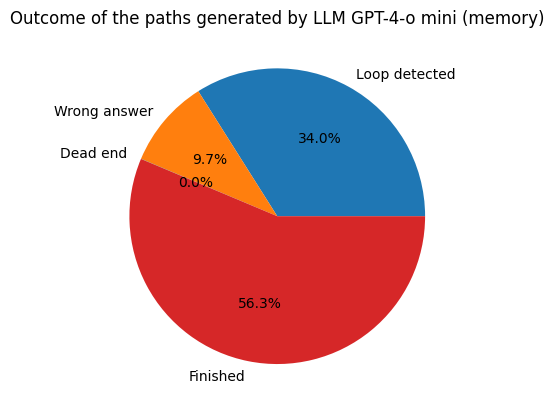

In [162]:
# get the pie chart of the outcome of the llm run with memory
llm_paths_all_gpt4omini_memory_LD = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] == 'LOOP_DETECTED')]
llm_paths_all_gpt4omini_memory_WA = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] == 'WRONG_ANSWER')]
llm_paths_all_gpt4omini_memory_NL = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] == 'NO_LINK')]
llm_paths_all_gpt4omini_memory_finished = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK'])]

print("The number of finished paths ",len(llm_paths_all_gpt4omini_memory_finished))
print("The number of loop detected ",len(llm_paths_all_gpt4omini_memory_LD))
print("The number of wrong answer ",len(llm_paths_all_gpt4omini_memory_WA))
print("The number of dead end ",len(llm_paths_all_gpt4omini_memory_NL))

# pie chart of the outcome of the paths
labels = 'Loop detected', 'Wrong answer', 'Dead end', 'Finished'
sizes = [len(llm_paths_all_gpt4omini_memory_LD), len(llm_paths_all_gpt4omini_memory_WA), len(llm_paths_all_gpt4omini_memory_NL), len(llm_paths_all_gpt4omini_memory_finished)]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Outcome of the paths generated by LLM GPT-4-o mini (memory)')
plt.show()

Does the llm take on average more steps than the human?

In [163]:
# To compare the number of steps taken we need to filtered only the unfinished paths to get comparable fata
# filter out the rows with 0 steps to filter the unfinished paths
llm_paths_all_gpt4omini_memory = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['steps'] > 0]
# describe the data
llm_paths_all_gpt4omini_memory['steps'].describe()

count    7552.000000
mean        6.983316
std         4.778942
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        57.000000
Name: steps, dtype: float64

In [164]:
# create a column path_lengts counting the number of steps for each finished path
llm_paths_all_gpt4omini_memory['path_length'] = llm_paths_all_gpt4omini_memory['path'].apply(lambda x: len(x.split(';')) - 1)

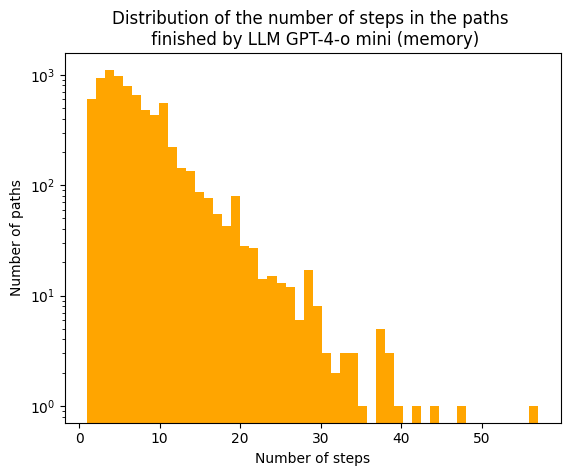

In [165]:
# plot the distribution of the number of steps in the finished paths
llm_paths_all_gpt4omini_memory['path_length'].hist(color='orange', bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the paths \n finished by LLM GPT-4-o mini (memory)')
plt.grid(False)
plt.yscale('log')

In [166]:
# To have a good comparaison it is nice to compare similar paths. This is why we take only the path_id that are in the 2 datasets
# create a mask using the past_id column
mask = paths_finished['path_id'].isin(llm_paths_all_gpt4omini_memory['path_id'])
paths_finished_filtered = paths_finished[mask]


# get the number of steps in the filtered paths
paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished_filtered['path_length'].describe()


/tmp/ipykernel_34802/1451920614.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)


count    7552.000000
mean        5.566870
std         6.244099
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max       434.000000
Name: path_length, dtype: float64

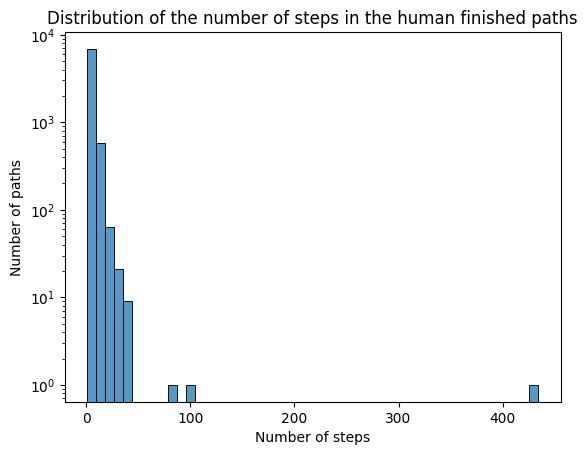

In [167]:
# plot the distribution of the number of steps in the filtered paths
sns.histplot(paths_finished_filtered['path_length'], bins=50)
plt.title('Distribution of the number of steps in the human finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.yscale('log')

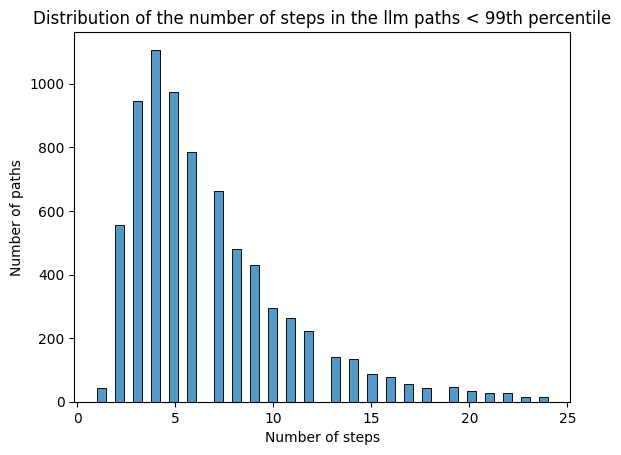

In [168]:
# we clearly see the existence of outliers. We therefore get the 99th percentile of the number of steps in the llm paths with memory
percentile_99 = np.percentile(llm_paths_all_gpt4omini_memory['path_length'], 99)

# plot the distribution of the number of steps in the llm paths that are less than the 90th percentile
llm_paths_all_gpt4omini_memory_lt_99 = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path_length'] < percentile_99]
sns.histplot(llm_paths_all_gpt4omini_memory_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the llm paths < 99th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

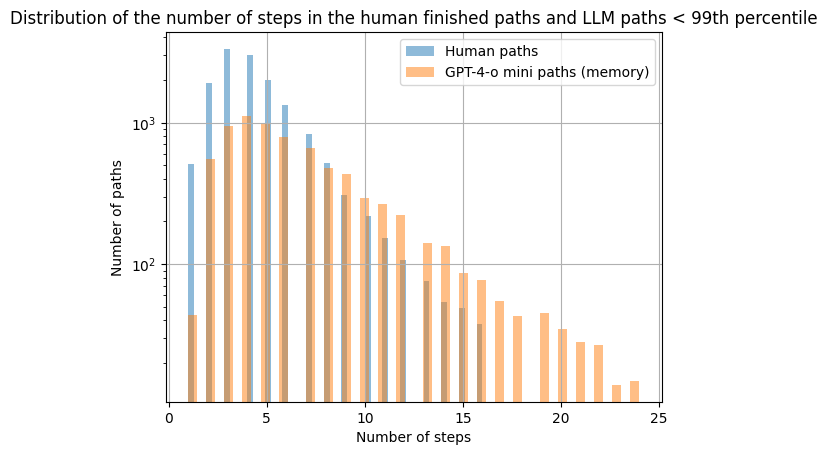

In [169]:
# compare the distribution of the number of steps in the finished paths filtered 99 percentile and the LLM paths filtered 99 percentile
paths_finished_filtered_lt_99['path_length'].hist(bins=50, alpha=0.5, label='Human paths')
llm_paths_all_gpt4omini_memory_lt_99['path_length'].hist(bins=50, alpha=0.5, label='GPT-4-o mini paths (memory)')
plt.title('Distribution of the number of steps in the human finished paths and LLM paths < 99th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

What is the distribution of the categories of articles passed by the llm or by the human?

In [170]:
# we reload to get the unfiltered dataset
llm_paths_all_gpt4omini_memory = pd.read_csv('data/llm_paths_all_gpt4omini_memory.tsv', sep='\t')

In [171]:
# get the articles that human goes to
articles_llm = llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_llm = [[item for item in sublist if item[0] != '<'] for sublist in articles_llm]

# get the categories of the articles
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)

articles_llm = [item for sublist in articles_llm for item in sublist]
# get the categories of the articles
categories_of_articles_llm = []
for article in articles_llm:
    try:
        categories_of_articles_llm.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_llm = [item for sublist in categories_of_articles_llm for item in sublist]
categories_count_llm = pd.Series(categories_of_articles_llm).value_counts()

# print the 5 most common categories
print(categories_count_llm.head())
nbr = categories_count_llm.quantile(0.70)

subject.Countries                                                  13368
subject.Science.Biology.General_Biology                             7519
subject.History.Ancient_History_Classical_History_and_Mythology     4973
subject.Geography.European_Geography.European_Countries             4754
subject.Citizenship.Politics_and_government                         4139
Name: count, dtype: int64


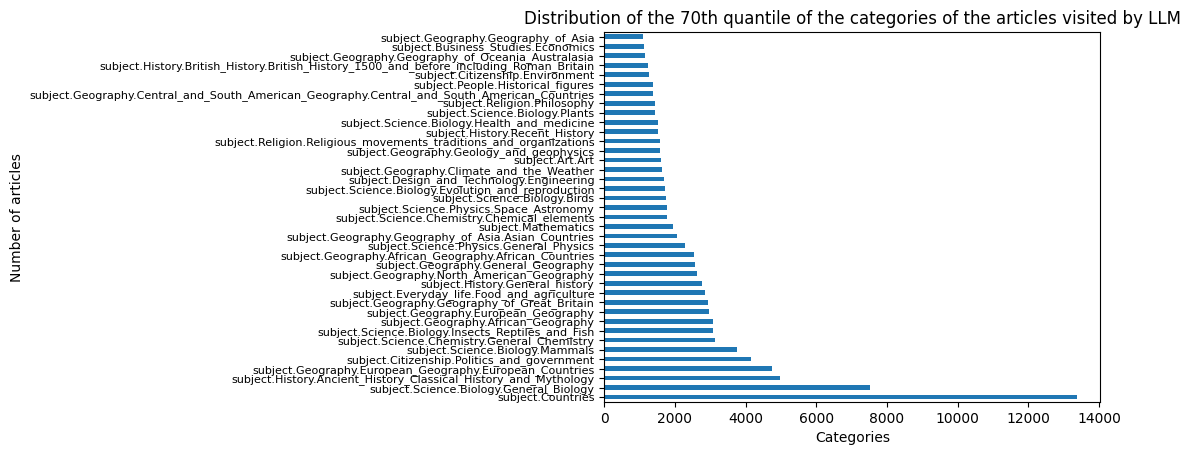

In [172]:
# plot the distribution of the 70th quantile
categories_count_llm[categories_count_llm > nbr].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by LLM')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

Now we compare the articles passed by the llm and the human. Does the llm pass more articles than the human?

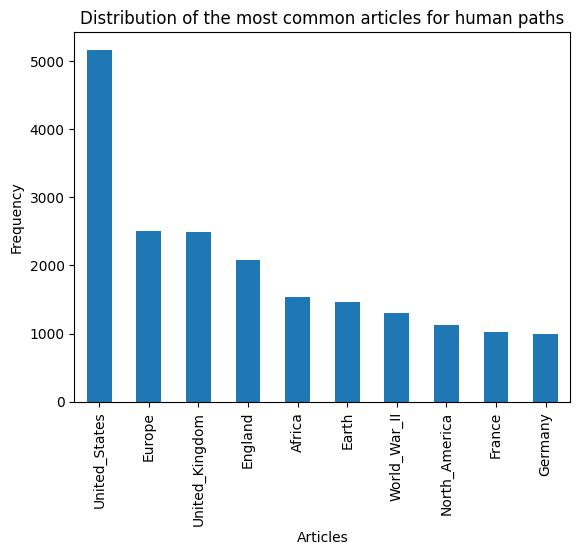

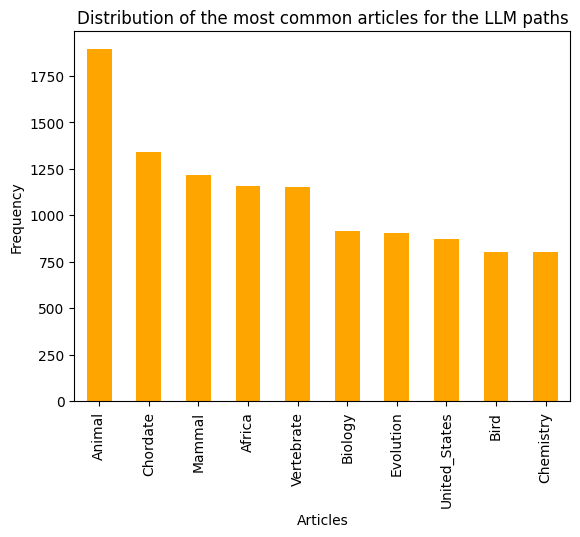

In [174]:

# Plot the distribution of the most common articles
articles_count_h = pd.Series(articles_human)
articles_count_h = articles_count_h.value_counts()
articles_count_h = articles_count_h.sort_values(ascending=False)
articles_count_h = articles_count_h[:10]
articles_count_h.plot(kind='bar')
plt.title('Distribution of the most common articles for human paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# from articles_llm, drop the loop_detected, wrong_answer and no_link
articles_llm = [item for item in articles_llm if item not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK']]


# Plot the distribution of the most common articles
articles_count = pd.Series(articles_llm)
articles_count = articles_count.value_counts()
articles_count = articles_count.sort_values(ascending=False)
articles_count = articles_count[:10]
articles_count.plot(kind='bar', color='orange')
plt.title('Distribution of the most common articles for the LLM paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()



In [175]:
import pandas as pd
import matplotlib.pyplot as plt

### Comparing OpenAi LLM with MistralAI LLM

We begin by finding the number of rows to get a statistical significant result.

In [177]:
# get the number of rows in the data
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t', skiprows=1, names=['path_id', 'hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
print('Number of rows in paths_finished:', paths_finished.shape[0])

Number of rows in paths_finished: 28718


In [178]:
# The runing of mistral is way longer that openai (limited by the rate limit)
# as the data is too large, we can calculate the necessary number of rows using the Z-score
# Z-score = 1.96 for 95% confidence interval
# margin of error = 5%
# population proportion = 0.5
Z = 1.96
margin_of_error = 0.05
p = 0.5
n = (Z**2 * p * (1-p)) / margin_of_error**2
print('Number of rows needed:', n)

Number of rows needed: 384.1599999999999


Using the Z-score, for a 95% confidence interval, the minimum number of rows needed to get a statistical significant result is 385. We therefore take randomly 565 rows from the dataset.

In [179]:
# Load the merged_file_mistral.tsv file
# Load the TSV file
file_path = "data/merged_file_final_mistral.tsv"
df_mistral = pd.read_csv(file_path, sep="\t")


In [180]:
# load the data/llm_paths.tsv file
# Load the TSV file
file_path = "data/llm_paths_all_gpt4omini_no_memory.tsv"
df_openai = pd.read_csv(file_path, sep="\t")

In [181]:
# print the number of rows in the df_openai DataFrame
num_rows = df_openai.shape[0]
print(f"Number of rows in the file: {num_rows}")

# print the number of rows in the df_mistral DataFrame
num_rows = df_mistral.shape[0]
print(f"Number of rows in the file: {num_rows}")    

Number of rows in the file: 28718
Number of rows in the file: 565


In [182]:
# get only the rows in the openai file that have the same path_id as the mistral file
# get the path_ids from the mistral file
mistral_path_ids = df_mistral["path_id"]

# filter the openai file based on the path_ids
df_openai = df_openai[df_openai["path_id"].isin(mistral_path_ids)]

In [183]:
# get only the rows in the mistral file that have the same path_id as the openai file
# get the path_ids from the openai file
openai_path_ids = df_openai["path_id"]

# filter the mistral file based on the path_ids
df_mistral = df_mistral[df_mistral["path_id"].isin(openai_path_ids)]


In [184]:
# get the number of rows in the filtered openai file
num_rows_filtered = df_openai.shape[0]
print(f"Number of rows in the filtered file: {num_rows}")

# get the number of rows in the filtered mistral file
num_rows_filtered = df_mistral.shape[0]
print(f"Number of rows in the filtered file: {num_rows}")

Number of rows in the filtered file: 565
Number of rows in the filtered file: 565


In [185]:
# check if the path of each row contain the string "WRONG_ANSWER"
df_openai_WA = df_openai[df_openai['path'].str.contains("WRONG_ANSWER")]
df_mistral_WA = df_mistral[df_mistral['path'].str.contains("WRONG_ANSWER")]

# get the number of rows in the df_openai_WA and df_mistral_WA DataFrames
num_rows_openai_WA = df_openai_WA.shape[0]
num_rows_mistral_WA = df_mistral_WA.shape[0]

# get the pourcentage of wrong answers 
pourcentage_openai_WA = (num_rows_openai_WA/num_rows)*100
pourcentage_mistral_WA = (num_rows_mistral_WA/num_rows)*100

print(f"Pourcentage of wrong answers in the OpenAI file: {pourcentage_openai_WA}%")
print(f"Pourcentage of wrong answers in the Mistral file: {pourcentage_mistral_WA}%")

Pourcentage of wrong answers in the OpenAI file: 4.95575221238938%
Pourcentage of wrong answers in the Mistral file: 32.92035398230089%


In [186]:
# check if the path of each row contain the string "LOOP_DETECTED"
df_openai_LD = df_openai[df_openai['path'].str.contains("LOOP_DETECTED")]
df_mistral_LD = df_mistral[df_mistral['path'].str.contains("LOOP_DETECTED")]

# get the number of rows in the df_openai_LD and df_mistral_LD DataFrames
num_rows_openai_LD = df_openai_LD.shape[0]
num_rows_mistral_LD = df_mistral_LD.shape[0]

# get the pourcentage of loop detected
pourcentage_openai_LD = (num_rows_openai_LD/num_rows)*100
pourcentage_mistral_LD = (num_rows_mistral_LD/num_rows)*100

print(f"Pourcentage of loop detected in the OpenAI file: {pourcentage_openai_LD}%")
print(f"Pourcentage of loop detected in the Mistral file: {pourcentage_mistral_LD}%")

Pourcentage of loop detected in the OpenAI file: 39.823008849557525%
Pourcentage of loop detected in the Mistral file: 14.513274336283185%


Pourcentage of finished paths in the OpenAI file: 55.2212389380531%
Pourcentage of finished paths in the Mistral file: 52.56637168141592%


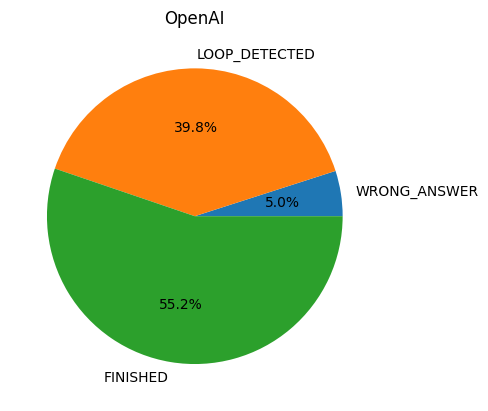

Text(0.5, 1.0, 'Mistral')

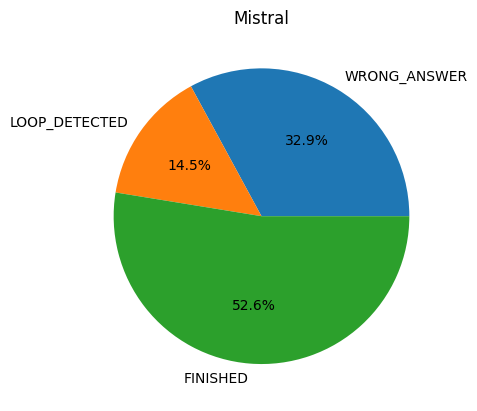

In [187]:
# the number of finished paths is therefore all the other paths
num_rows_openai_finished = num_rows_filtered - num_rows_openai_WA - num_rows_openai_LD
num_rows_mistral_finished = num_rows_filtered - num_rows_mistral_WA - num_rows_mistral_LD

# get the pourcentage of finished paths
pourcentage_openai_finished = (num_rows_openai_finished/num_rows_filtered)*100
pourcentage_mistral_finished = (num_rows_mistral_finished/num_rows_filtered)*100

print(f"Pourcentage of finished paths in the OpenAI file: {pourcentage_openai_finished}%")
print(f"Pourcentage of finished paths in the Mistral file: {pourcentage_mistral_finished}%")

# plot 2 piechart to show the results
labels = ['WRONG_ANSWER', 'LOOP_DETECTED', 'FINISHED']
sizes_openai = [pourcentage_openai_WA, pourcentage_openai_LD, pourcentage_openai_finished]
sizes_mistral = [pourcentage_mistral_WA, pourcentage_mistral_LD, pourcentage_mistral_finished]
fig, ax = plt.subplots()
ax.pie(sizes_openai, labels=labels, autopct='%1.1f%%')
ax.set_title('OpenAI')
plt.show()
fig, ax = plt.subplots()
ax.pie(sizes_mistral, labels=labels, autopct='%1.1f%%')
ax.set_title('Mistral')

We can see that for both llm the success rate is similar. However, openai tends to loop more and mistralai tends to give more wrong answers. This can show differents digital minds.

In [188]:
# get the percentage of unfinished paths in the openai file
num_rows_openai = df_openai.shape[0]

# the unfinished paths are the paths that contains the string "LOOP_DETECTED" or "WRONG_ANSWER"
df_openai_unfinished = df_openai[df_openai['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]
num_rows_openai_unfinished = df_openai_unfinished.shape[0]
pourcentage_openai_unfinished = (num_rows_openai_unfinished/num_rows_openai)*100
print(f"Pourcentage of unfinished paths in the OpenAI file: {pourcentage_openai_unfinished}%")

Pourcentage of unfinished paths in the OpenAI file: 44.7787610619469%


In [189]:
# get the percentage of unfinished paths in the mistral file
num_rows_mistral = df_mistral.shape[0]

# the unfinished paths are the paths that contains the string "LOOP_DETECTED" or "WRONG_ANSWER"
df_mistral_unfinished = df_mistral[df_mistral['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]
num_rows_mistral_unfinished = df_mistral_unfinished.shape[0]

pourcentage_mistral_unfinished = (num_rows_mistral_unfinished/num_rows_mistral)*100
print(f"Pourcentage of unfinished paths in the Mistral file: {pourcentage_mistral_unfinished}%")

Pourcentage of unfinished paths in the Mistral file: 47.43362831858407%


In [190]:
df_mistral_finished = df_mistral[~df_mistral['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]
df_openai_finished = df_openai[~df_openai['path'].str.contains("LOOP_DETECTED|WRONG_ANSWER")]

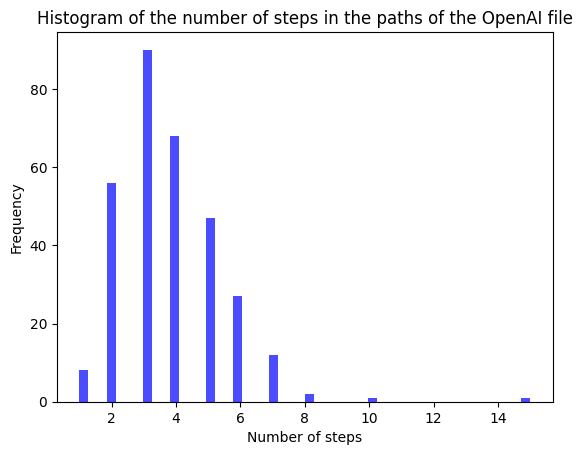

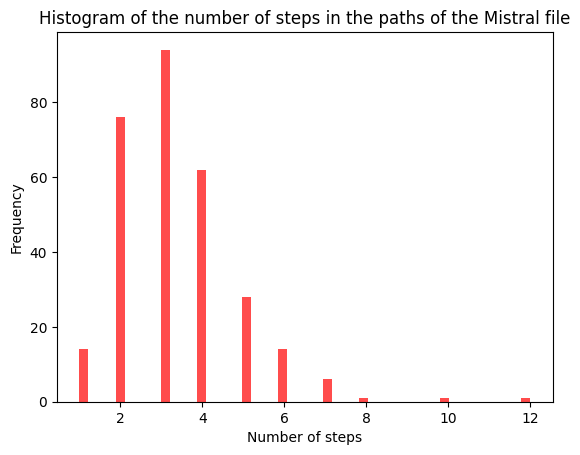

In [191]:
# we want to compare the number of steps in the paths of the openai and mistral files (column steps)


# plot the histogram of the number of steps in the paths of the openai file

plt.hist(df_openai_finished['steps'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.title('Histogram of the number of steps in the paths of the OpenAI file')
plt.show()

# plot the histogram of the number of steps in the paths of the mistral file
plt.hist(df_mistral_finished['steps'], bins=50, color='red', alpha=0.7)
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.title('Histogram of the number of steps in the paths of the Mistral file')
plt.show() 

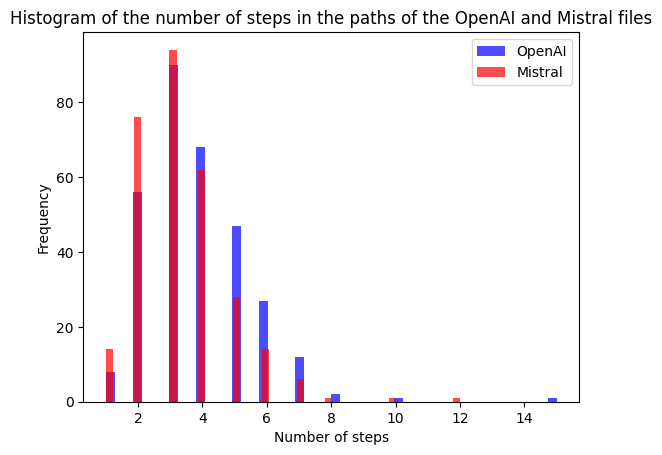

In [192]:
# compare the 2 graphs above
plt.hist(df_openai_finished['steps'], bins=50, color='blue', alpha=0.7, label='OpenAI')
plt.hist(df_mistral_finished['steps'], bins=50, color='red', alpha=0.7, label='Mistral')
plt.xlabel('Number of steps')
plt.ylabel('Frequency')
plt.title('Histogram of the number of steps in the paths of the OpenAI and Mistral files')
plt.legend()
plt.show() 

In [193]:
# describe the steps column of the openai file
df_openai['steps'].describe()


count    565.000000
mean       2.095575
std        2.242734
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       15.000000
Name: steps, dtype: float64

In [194]:
# describe the steps column of the mistral file
df_mistral['steps'].describe()

count    565.000000
mean       1.755752
std        1.984110
min        0.000000
25%        0.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: steps, dtype: float64

In [195]:
import urllib.parse
# load categories.tsv file
# Load the TSV file
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)


In [196]:

articles_openai = df_openai['path'].apply(lambda x: x.split(';')).tolist()

articles_openai = [item for sublist in articles_openai for item in sublist]

# get the cartegoies of the articles
categories_of_articles_openai = []
for article in articles_openai:
    try:
        categories_of_articles_openai.append(categories[categories['article'] == article]['category'])
    except:
        pass

# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_openai = [item for sublist in categories_of_articles_openai for item in sublist]
categories_count_openai = pd.Series(categories_of_articles_openai).value_counts()

# print the 5 most common categories
print(categories_count_openai.head())
nbr_o = categories_count_openai.quantile(0.70)

subject.Countries                                          369
subject.History.General_history                            204
subject.Geography.European_Geography.European_Countries    138
subject.Citizenship.Politics_and_government                125
subject.Geography.North_American_Geography                 106
Name: count, dtype: int64


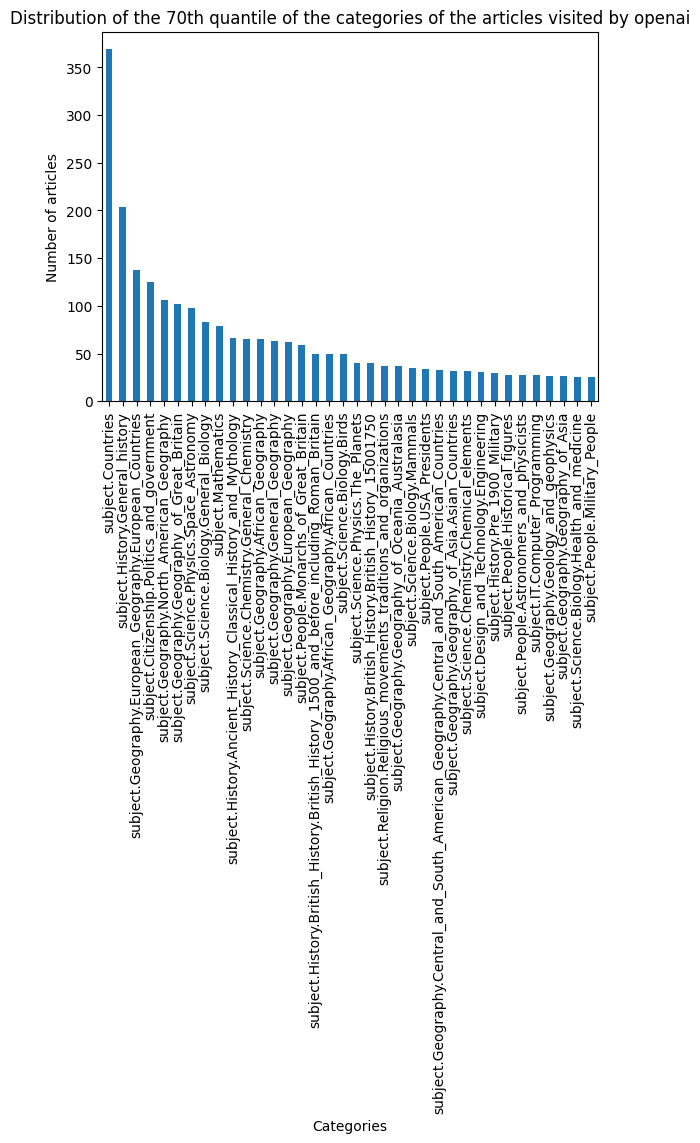

In [197]:
# plot the distribution of the 70th quantile
categories_count_openai[categories_count_openai > nbr_o].plot(kind='bar')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by openai')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.show()

In [198]:

articles_mistral = df_mistral['path'].apply(lambda x: x.split(';')).tolist()

articles_mistral = [item for sublist in articles_mistral for item in sublist]

# get the cartegoies of the articles
categories_of_articles_mistral = []
for article in articles_mistral:
    try:
        categories_of_articles_mistral.append(categories[categories['article'] == article]['category'])
    except:
        pass

# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_mistral = [item for sublist in categories_of_articles_mistral for item in sublist]
categories_count_mistral = pd.Series(categories_of_articles_mistral).value_counts()

# print the 5 most common categories
print(categories_count_mistral.head())
nbr_m = categories_count_mistral.quantile(0.70)

subject.Countries                                          290
subject.Geography.European_Geography.European_Countries    119
subject.Geography.North_American_Geography                 100
subject.Geography.Geography_of_Great_Britain                99
subject.History.General_history                             89
Name: count, dtype: int64


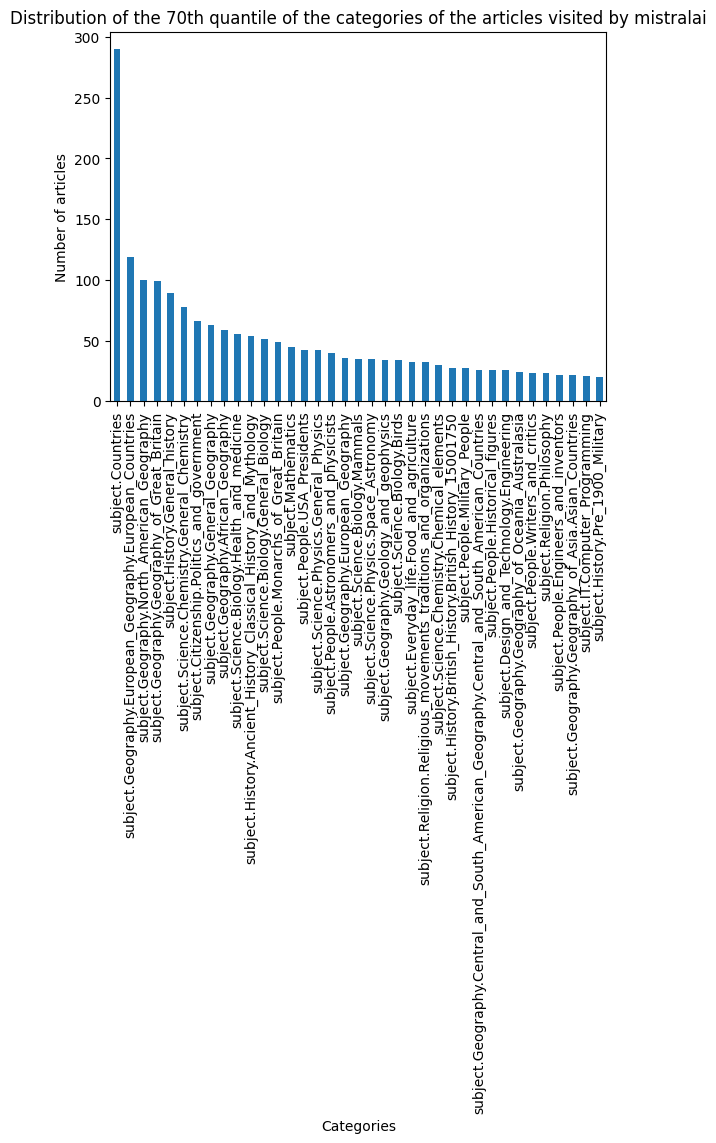

In [199]:
# plot the distribution of the 70th quantile
categories_count_mistral[categories_count_mistral > nbr_m].plot(kind='bar')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by mistralai')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.show()

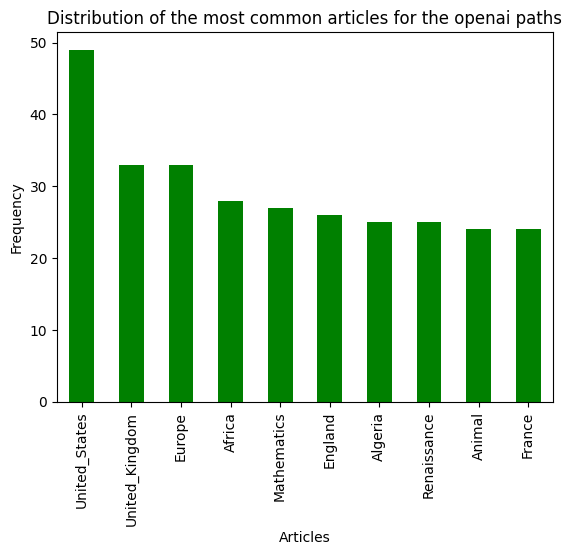

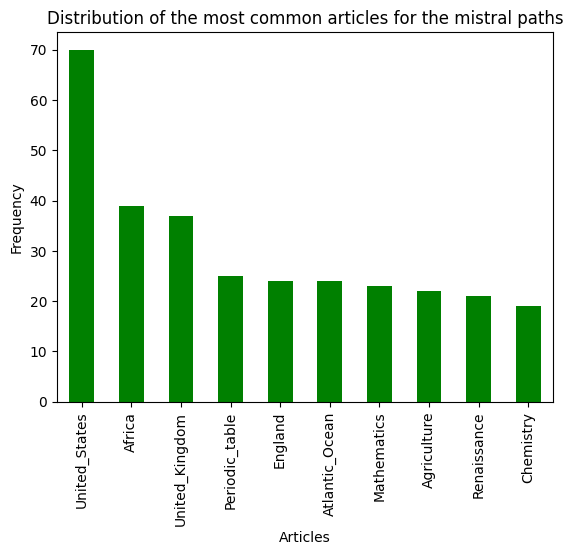

In [200]:

# drop the loop_detected and wrong_answer articles
articles_openai = [article for article in articles_openai if article not in ['LOOP_DETECTED', 'WRONG_ANSWER']]


# Plot the distribution of the most common articles
articles_count_openai = pd.Series(articles_openai)
articles_count_openai = articles_count_openai.value_counts()
articles_count_openai = articles_count_openai.sort_values(ascending=False)
articles_count_openai = articles_count_openai[:10]
articles_count_openai.plot(kind='bar', color='green')
plt.title('Distribution of the most common articles for the openai paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# drop the loop_detected and wrong_answer articles
articles_mistral = [article for article in articles_mistral if article not in ['LOOP_DETECTED', 'WRONG_ANSWER']]



# Plot the distribution of the most common articles
articles_count_mistral = pd.Series(articles_mistral)
articles_count_mistral = articles_count_mistral.value_counts()
articles_count_mistral = articles_count_mistral.sort_values(ascending=False)
articles_count_mistral = articles_count_mistral[:10]
articles_count_mistral.plot(kind='bar', color='green')
plt.title('Distribution of the most common articles for the mistral paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()

